# Exercise 1

# Repeat Exercise 1 of Part 4 (NLP with RNNs), now using a stacked CNN with n-gram filters (e.g., 𝑛 = 2, 3, 4), residual connections, and global max-pooling at the top layer, all implemented in Keras/TensorFlow or PyTorch.

# Steps:

1. Tune the hyper-parameters
(e.g., values of 𝑛, number of stacked convolutional layers) on the development subset of the dataset.

2. Monitor the performance of your models on the development subset during training
to decide how many epochs to use. You may optionally add an extra CNN layer to produce
word embeddings from characters, concatenating each resulting character-based
word embedding with the corresponding pre-trained word embedding (e.g., obtained with
Word2Vec).

3. Include experimental results of a baseline majority classifier, as well as
experimental results of your best classifiers from exercise 15 of Part 2, exercise 9 of Part 3,
and exercise 1 of Part 4. Otherwise, the contents of your report should be as in exercise 1 of
Part 4, but now with information and results for the experiments of this exercise.

4. You may
optionally wish to try ensembles (e.g., majority voting of the best checkpoints, temporal
averaging of the weights of the best checkpoints, combining RNN and CNN classifiers).



# Report:
- Curves showing the loss on training and development data as a function of epochs.
- Precision, recall, F1, precision-recall AUC scores for each class and classifier:
   - Separate for the training, development, and test subsets.
- Macro-averaged precision, recall, F1, precision-recall AUC scores:
   - Averaging the corresponding scores over the classes, separately for the training, development, and test subsets.
- Description of the methods and datasets used:
   - Include statistics like average document length, number of training/dev/test documents, and vocabulary size.
   - Describe preprocessing steps performed.
- Optionally, try ensemble methods (e.g., majority voting of the best checkpoints, temporal averaging of the weights of the best checkpoints).


## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


## Assert whether ``PyTorch`` can use an available GPU card

## Creating a Dataset

We will use the ``Dataset`` class from ``PyTorch`` to handle the text data. We will pad the text sequences with $0$ to a pre-defined length (the average number of tokens in the training split).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from torch.utils.data import DataLoader, TensorDataset
import gensim.downloader as api
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')

Using device: cuda


True

In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/Fake.csv")
df_true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Text Analytics Assignment 2/Dataset/True.csv")


In [ ]:
df_fake["label"] = 1
df_true["label"] = 0

In [ ]:
df_merge = pd.concat([df_fake, df_true], axis =0 )
df_merge.head(10)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1


In [ ]:
#Removing columns which are not required¶
df = df_merge.drop(["title", "subject","date"], axis = 1)

df.reset_index(inplace = True)
df.drop(["index"], axis = 1, inplace = True)
df.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize text
    return ' '.join(tokens)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into features (X) and target labels (y)
X = df['text'].values
y = df['label'].values

# Split into training, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=2025, stratify=y_temp)

# Check the distribution of labels in each set
print("Training set class distribution:", np.bincount(y_train))
print("Validation set class distribution:", np.bincount(y_val))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [17133 18785]
Validation set class distribution: [2142 2348]
Test set class distribution: [2142 2348]


In [ ]:
# Preprocess all splits
X_train = [preprocess_text(text) for text in X_train]
X_val = [preprocess_text(text) for text in X_val]
X_test = [preprocess_text(text) for text in X_test]

In [ ]:
import numpy as np
from collections import Counter
import string

# Function to calculate dataset statistics and preprocessing steps
def dataset_stats_and_preprocessing(df, X_train, X_val, X_test):
    # Number of documents
    num_train = len(X_train)
    num_val = len(X_val)
    num_test = len(X_test)

    # Average document length (in terms of word count)
    avg_train_length = np.mean([len(doc.split()) for doc in X_train])
    avg_val_length = np.mean([len(doc.split()) for doc in X_val])
    avg_test_length = np.mean([len(doc.split()) for doc in X_test])

    # Vocabulary size (unique words in the whole corpus)
    all_text = ' '.join(df['text'].values)
    all_words = all_text.split()
    vocab_size = len(set(all_words))

    # Preprocessing steps description
    preprocessing_steps = """
    1. Text Tokenization: The text is split into words based on spaces. Punctuation is included as part of words (can be changed based on need).
    2. Stop-word Removal: If implemented, remove common words that don't carry useful information (e.g., "the", "and").
    3. Lowercasing: The text is converted to lowercase to ensure uniformity.
    """

    # Displaying the calculated statistics
    print(f"Total documents: {len(df)}")
    print(f"Fake news: {len(df[df['label'] == 1])}, True news: {len(df[df['label'] == 0])}")
    print(f"Number of training documents: {num_train}")
    print(f"Number of validation documents: {num_val}")
    print(f"Number of test documents: {num_test}")
    print(f"Average document length in training set (in words): {round(avg_train_length)}")
    print(f"Average document length in validation set (in words): {round(avg_val_length)}")
    print(f"Average document length in test set (in words): {round(avg_test_length)}")
    print(f"Vocabulary size (unique words): {vocab_size}")


    return {
        "num_train": num_train,
        "num_val": num_val,
        "num_test": num_test,
        "avg_train_length": avg_train_length,
        "avg_val_length": avg_val_length,
        "avg_test_length": avg_test_length,
        "vocab_size": vocab_size,
        "preprocessing_steps": preprocessing_steps
    }


dataset_info = dataset_stats_and_preprocessing(df, X_train, X_val, X_test)


Total documents: 44898
Fake news: 23481, True news: 21417
Number of training documents: 35918
Number of validation documents: 4490
Number of test documents: 4490
Average document length in training set (in words): 400
Average document length in validation set (in words): 396
Average document length in test set (in words): 402
Vocabulary size (unique words): 397481


In [ ]:
# Create custom vocabulary using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(X_train)
custom_vocab = vectorizer.vocabulary_

# Load GloVe embeddings using gensim downloader
glove = api.load("glove-wiki-gigaword-300")  # Load the GloVe embeddings

# Map custom vocabulary to GloVe indices with 'PAD' and 'UNK' tokens
embedding_dim = 300
average_embedding = np.mean(glove.vectors, axis=0)  # average of all embeddings
vocab = {'PAD': 0, 'UNK': 1}
vocab.update({word: idx + 2 for idx, word in enumerate(custom_vocab)})
embedding_matrix = np.zeros((len(vocab), embedding_dim))
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD token embedding
embedding_matrix[1] = average_embedding  # UNK token embedding
for word, idx in vocab.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
    elif idx > 1:
        embedding_matrix[idx] = average_embedding

del glove

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
avg_train_length = np.mean([len(doc.split()) for doc in X_train])
avg_val_length = np.mean([len(doc.split()) for doc in X_val])
avg_test_length = np.mean([len(doc.split()) for doc in X_test])

# Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length):
        self.texts = [self.tokenize(text, vocab, max_length) for text in texts]
        self.labels = labels

    def tokenize(self, text, vocab, max_length):
        text = text.lower().split()
        tokens = [vocab.get(word, vocab['UNK']) for word in text]
        if len(tokens) < max_length:
            tokens += [vocab['PAD']] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        return tokens

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.labels[idx])

train_dataset = TextDataset(X_train, y_train, vocab, int(avg_train_length))
val_dataset = TextDataset(X_val, y_val, vocab, int(avg_val_length))
test_dataset = TextDataset(X_test, y_test, vocab, int(avg_test_length))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

## Define the model

We will create a model class and parameterize our neural network with several choices

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, output_dim, attention_dim=None,
                 num_filters=100, ngram_kernel_size=2,
                 pretrained_embeddings=True, freeze_embeddings=False,
                 num_layers=1,
                 use_pooling=False, use_attention=False, dropout=0.3):
        super(CNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.attention_mlp = None
        self.dropout = dropout

        assert self.use_pooling or self.use_attention
        if self.use_pooling:
            assert not self.use_attention, "Cannot use pooling and attention at the same time"
        elif self.use_attention:
            assert not self.use_pooling, "Cannot use pooling and attention at the same time"

        if pretrained_embeddings:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                             dtype=torch.float32),
                                                                                                freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.conv_layers = nn.ModuleList()
        for layer_idx in range(num_layers):
            in_channels = embed_dim if layer_idx == 0 else num_filters
            self.conv_layers.append(nn.Conv1d(in_channels=in_channels,
                                            out_channels=num_filters,
                                            kernel_size=ngram_kernel_size,
                                            padding='valid'))

        self.fc = nn.Linear(num_filters, output_dim)

        # Dropout layer after the convolution layers
        self.drop = nn.Dropout(self.dropout)

        if self.use_attention:
            assert attention_dim is not None, "Attention dimension must be specified"
            self.attention_mlp = torch.nn.Sequential(
                torch.nn.Linear(num_filters, attention_dim),
                torch.nn.Tanh(),
                torch.nn.Linear(attention_dim, 1)
            )

    def forward(self, x):
        z = self.embedding(x)
        z = z.transpose(1, 2)

        for layer_idx in range(len(self.conv_layers)):
            z = self.conv_layers[layer_idx](z)
            z = torch.nn.ReLU()(z)
            z = self.drop(z)  # Apply dropout after each convolution

        if self.use_pooling:
            pooling = nn.AdaptiveMaxPool1d(output_size=1)
            pooled = pooling(z).squeeze()
            return self.fc(pooled)
        elif self.use_attention:
            attention_weights = self.attention_mlp(z.transpose(1, 2))
            attention_weights = torch.softmax(attention_weights, dim=1)
            attention_output = torch.sum(z.transpose(1, 2) * attention_weights, dim=1)
            return self.fc(attention_output)


In [ ]:
class MultiFilterCNNModel(nn.Module):
    def __init__(self, vocab_size,
                 embed_dim, output_dim, attention_dim=None,
                 num_filters=100,
                 pretrained_embeddings=True, freeze_embeddings=False,
                 num_layers=1,
                 use_pooling=False, use_attention=False, dropout=0.3):
        super(MultiFilterCNNModel, self).__init__()
        self.use_pooling = use_pooling
        self.use_attention = use_attention
        self.attention_mlp = None
        self.dropout = dropout

        assert self.use_pooling or self.use_attention
        if self.use_pooling:
            assert not self.use_attention, "Cannot use pooling and attention at the same time"
        elif self.use_attention:
            assert not self.use_pooling, "Cannot use pooling and attention at the same time"

        if pretrained_embeddings:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0).from_pretrained(torch.tensor(embedding_matrix,
                                                                                                         dtype=torch.float32),
                                                                                            freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.embeddings_projection = nn.Linear(embed_dim, num_filters)

        self.bigram_layers = nn.ModuleList()
        self.trigram_layers = nn.ModuleList()
        self.fourgram_layers = nn.ModuleList()
        for layer_idx in range(num_layers):
            in_channels = num_filters
            self.bigram_layers.append(nn.Conv1d(in_channels=in_channels,
                                                out_channels=num_filters,
                                                kernel_size=2,
                                                padding='same'))
            self.trigram_layers.append(nn.Conv1d(in_channels=in_channels,
                                                 out_channels=num_filters,
                                                 kernel_size=3,
                                                 padding='same'))
            self.fourgram_layers.append(nn.Conv1d(in_channels=in_channels,
                                                  out_channels=num_filters,
                                                  kernel_size=4,
                                                  padding='same'))

        self.global_max_pooling = nn.AdaptiveMaxPool1d(output_size=1)
        self.fc = nn.Linear(num_filters * 3, output_dim)

        # Dropout layer after convolutions
        self.drop = nn.Dropout(self.dropout)

        if self.use_attention:
            assert attention_dim is not None, "Attention dimension must be specified"
            self.attention_mlp = torch.nn.Sequential(
                nn.Linear(num_filters * 3, attention_dim),
                nn.Tanh(),
                nn.Linear(attention_dim, 1)
            )

    def forward(self, x):
        z = self.embedding(x)
        z = self.embeddings_projection(z)
        z = z.transpose(1, 2)

        bigram, residual_bigram = z, z
        trigram, residual_trigram = z, z
        fourgram, residual_fourgram = z, z

        for bigram_layer, trigram_layer, fourgram_layer in zip(self.bigram_layers, self.trigram_layers, self.fourgram_layers):
            bigram = bigram_layer(bigram)
            bigram = torch.nn.ReLU()(bigram)
            bigram = bigram + residual_bigram
            residual_bigram = bigram

            trigram = trigram_layer(trigram)
            trigram = torch.nn.ReLU()(trigram)
            trigram = trigram + residual_trigram
            residual_trigram = trigram

            fourgram = fourgram_layer(fourgram)
            fourgram = torch.nn.ReLU()(fourgram)
            fourgram = fourgram + residual_fourgram
            residual_fourgram = fourgram

        bigram = self.drop(bigram)  # Apply dropout
        trigram = self.drop(trigram)  # Apply dropout
        fourgram = self.drop(fourgram)  # Apply dropout

        if self.use_pooling:
            bigram = self.global_max_pooling(bigram).squeeze()
            trigram = self.global_max_pooling(trigram).squeeze()
            fourgram = self.global_max_pooling(fourgram).squeeze()

        if self.use_attention:
            bigram_attention_weights = self.attention_mlp(bigram.transpose(1, 2))
            bigram_attention_weights = torch.softmax(bigram_attention_weights, dim=1)
            bigram = torch.sum(bigram.transpose(1, 2) * bigram_attention_weights, dim=1)

            trigram_attention_weights = self.attention_mlp(trigram.transpose(1, 2))
            trigram_attention_weights = torch.softmax(trigram_attention_weights, dim=1)
            trigram = torch.sum(trigram.transpose(1, 2) * trigram_attention_weights, dim=1)

            fourgram_attention_weights = self.attention_mlp(fourgram.transpose(1, 2))
            fourgram_attention_weights = torch.softmax(fourgram_attention_weights, dim=1)
            fourgram = torch.sum(fourgram.transpose(1, 2) * fourgram_attention_weights, dim=1)

        output = torch.cat((bigram, trigram, fourgram), dim=1)

        return self.fc(output)


In [ ]:
# Modify the get_predictions function:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No need to compute gradients during inference
        for batch in data_loader:
            # If batch is a tuple, unpack it accordingly
            inputs, labels = batch  # Assumes batch is (inputs, labels) tuple
            inputs = inputs.to(device)  # Move inputs to the correct device (GPU/CPU)
            labels = labels.to(device)  # Move labels to the correct device
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())  # Collect predictions
            all_labels.append(labels.cpu().numpy())  # Collect true labels

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds  # Return true labels and predictions


In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
target_names = ['True News', 'Fake News']

# Instantiate models and train
num_classes = len(np.unique(y_train))
models = {'BigramCNN_GMP': CNNModel(vocab_size=len(vocab), embed_dim=300,
                          output_dim=num_classes,
                          num_filters=64, ngram_kernel_size=2,
                          num_layers=3,
                          use_pooling=True,
                          dropout=0.3),

'TrigramCNN_GMP': CNNModel(vocab_size=len(vocab), embed_dim=300,
                           output_dim=num_classes,
                           num_filters=64, ngram_kernel_size=3,
                           num_layers=3,
                           use_pooling=True,
                           dropout=0.3),

'FourgamCNN_GMP': CNNModel(vocab_size=len(vocab), embed_dim=300,
                           output_dim=num_classes,
                           num_filters=8, ngram_kernel_size=4,
                           num_layers=1,
                           use_pooling=True,
                           dropout=0.5),

'BigramCNN_Att': CNNModel(vocab_size=len(vocab), embed_dim=300,
                          output_dim=num_classes,
                          num_filters=64, ngram_kernel_size=2,
                          num_layers=3,
                          use_attention=True, attention_dim=16,
                          dropout=0.3),

'BigramCNN_GMP_RandomInit': CNNModel(vocab_size=len(vocab), embed_dim=300,
                                     output_dim=num_classes,
                                     num_filters=64, ngram_kernel_size=2,
                                     num_layers=3,
                                     pretrained_embeddings=False,
                                     use_pooling=True,
                                     dropout=0.4),

'BigramCNN_GMP_FreezeEmb': CNNModel(vocab_size=len(vocab), embed_dim=300,
                                    output_dim=num_classes,
                                    num_filters=64, ngram_kernel_size=2,
                                    num_layers=3,
                                    freeze_embeddings=True,
                                    use_pooling=True,
                                    dropout=0.3),

'MultiFilterCNN_GMP': MultiFilterCNNModel(
    vocab_size=len(vocab), embed_dim=300, output_dim=num_classes,
    num_filters=16, num_layers=2, use_pooling=True,
    dropout=0.4)
}

results = {}
epochs = 20
patience = 5  # Number of epochs to wait for improvement before stopping early
for name, model in models.items():
    model = model.to(device)  # Ensure the model uses CUDA if available
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    print(f"Training {name}...")
    print("=" * 50)

    # Initialize lists for metrics
    train_losses, val_losses = [], []
    acc_train, acc_val = [], []
    pr_auc_train, pr_auc_val, pr_auc_test = [], [], []
    class_reports = {'train': [], 'val': [], 'test': []}

    best_val_loss = float('inf')  # Best validation loss seen so far
    epochs_no_improve = 0  # Counter for epochs without improvement

    # Use tqdm for the training loop
    for epoch in tqdm(range(epochs), desc=f"Training {name}", unit="epoch"):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Store training loss and accuracy
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_train / total_train
        acc_train.append(train_accuracy)

        # Validation loss and accuracy
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct_val / total_val
        acc_val.append(val_accuracy)

        # Get predictions and calculate metrics for train, val, and test
        y_true_train, y_pred_train = get_predictions(model, train_loader)
        y_true_val, y_pred_val = get_predictions(model, val_loader)
        y_true_test, y_pred_test = get_predictions(model, test_loader)

        # Compute Precision-Recall AUC for each set
        precision_train, recall_train, _ = precision_recall_curve(y_true_train, y_pred_train)
        precision_val, recall_val, _ = precision_recall_curve(y_true_val, y_pred_val)
        precision_test, recall_test, _ = precision_recall_curve(y_true_test, y_pred_test)

        pr_auc_train.append(auc(recall_train, precision_train))
        pr_auc_val.append(auc(recall_val, precision_val))
        pr_auc_test.append(auc(recall_test, precision_test))

        # Compute classification report
        class_reports['train'].append(classification_report(y_true_train, y_pred_train, target_names=target_names))
        class_reports['val'].append(classification_report(y_true_val, y_pred_val, target_names=target_names))
        class_reports['test'].append(classification_report(y_true_test, y_pred_test, target_names=target_names))

        # Print metrics for each epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {avg_val_loss:.4f}\n")

        # Early stopping: Check if validation loss has improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0  # Reset the counter
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Store results for this model
    results[name] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'accuracy_train': acc_train,
        'accuracy_val': acc_val,
        'pr_auc_train': pr_auc_train,
        'pr_auc_val': pr_auc_val,
        'pr_auc_test': pr_auc_test,
        'classification_report_train': class_reports['train'],
        'classification_report_val': class_reports['val'],
        'classification_report_test': class_reports['test']
    }

    # Print final classification report for the model after training
    print(f"\nFinal Classification Report for {name}:\n")
    print(f"Training Classification Report:\n{class_reports['train'][-1]}")
    print(f"Validation Classification Report:\n{class_reports['val'][-1]}")
    print(f"Test Classification Report:\n{class_reports['test'][-1]}")

    # Print final Precision-Recall AUC scores
    print(f"Precision-Recall AUC Scores:")
    print(f"Training PR AUC: {pr_auc_train[-1]:.4f}")
    print(f"Validation PR AUC: {pr_auc_val[-1]:.4f}")
    print(f"Test PR AUC: {pr_auc_test[-1]:.4f}")
    print("=" * 50)


# Print final evaluation metrics for each model
for name, metrics in results.items():
    print(f"{name}:")
    print(f"Final Training Accuracy: {metrics['accuracy_train'][-1]:.4f}")
    print(f"Final Validation Accuracy: {metrics['accuracy_val'][-1]:.4f}")
    print(f"Final Precision-Recall AUC (Test): {metrics['pr_auc_test'][-1]:.4f}")
    print(f"Classification Report (Test):\n{metrics['classification_report_test'][-1]}")
    print("=" * 50)


Training BigramCNN_GMP...


Epoch 1/20
Training Accuracy: 0.9786, Training Loss: 0.0776
Validation Accuracy: 0.9942, Validation Loss: 0.0709



Epoch 2/20
Training Accuracy: 0.9835, Training Loss: 0.1214
Validation Accuracy: 0.9951, Validation Loss: 0.0446



Epoch 3/20
Training Accuracy: 0.9783, Training Loss: 0.1343
Validation Accuracy: 0.9955, Validation Loss: 0.1491



Epoch 4/20
Training Accuracy: 0.9877, Training Loss: 0.0811
Validation Accuracy: 0.9949, Validation Loss: 0.0531



Epoch 5/20
Training Accuracy: 0.9872, Training Loss: 0.0890
Validation Accuracy: 0.9940, Validation Loss: 0.0887



Epoch 6/20
Training Accuracy: 0.9861, Training Loss: 0.1042
Validation Accuracy: 0.9833, Validation Loss: 0.0816



Epoch 7/20
Training Accuracy: 0.9739, Training Loss: 0.1605
Validation Accuracy: 0.9940, Validation Loss: 0.2704

Early stopping triggered after 7 epochs

Final Classification Report for BigramCNN_GMP:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      0.99      0.99     17133
   Fake News       0.99      1.00      0.99     18785

    accuracy                           0.99     35918
   macro avg       0.99      0.99      0.99     35918
weighted avg       0.99      0.99      0.99     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      0.99      0.99      2142
   Fake News       0.99      1.00      0.99      2348

    accuracy                           0.99      4490
   macro avg       0.99      0.99      0.99      4490
weighted avg       0.99      0.99      0.99      4490

Test Classification Report:
              precision    recall  f1-score   sup

Epoch 1/20
Training Accuracy: 0.9763, Training Loss: 0.0893
Validation Accuracy: 0.9871, Validation Loss: 0.0885



Epoch 2/20
Training Accuracy: 0.9848, Training Loss: 0.1062
Validation Accuracy: 0.9947, Validation Loss: 0.0853



Epoch 3/20
Training Accuracy: 0.9868, Training Loss: 0.1106
Validation Accuracy: 0.9947, Validation Loss: 0.1462



Epoch 4/20
Training Accuracy: 0.9854, Training Loss: 0.1092
Validation Accuracy: 0.9964, Validation Loss: 0.2360



Epoch 5/20
Training Accuracy: 0.9744, Training Loss: 0.2138
Validation Accuracy: 0.9851, Validation Loss: 0.0906



Epoch 6/20
Training Accuracy: 0.9840, Training Loss: 0.1127
Validation Accuracy: 0.9886, Validation Loss: 0.0787



Epoch 7/20
Training Accuracy: 0.9888, Training Loss: 0.0809
Validation Accuracy: 0.9918, Validation Loss: 0.0474



Epoch 8/20
Training Accuracy: 0.9878, Training Loss: 0.0742
Validation Accuracy: 0.9913, Validation Loss: 0.0553



Epoch 9/20
Training Accuracy: 0.9781, Training Loss: 0.1300
Validation Accuracy: 0.9929, Validation Loss: 0.5059



Epoch 10/20
Training Accuracy: 0.9805, Training Loss: 0.2089
Validation Accuracy: 0.9940, Validation Loss: 0.1287



Epoch 11/20
Training Accuracy: 0.9797, Training Loss: 0.0997
Validation Accuracy: 0.9947, Validation Loss: 0.3780



Epoch 12/20
Training Accuracy: 0.9810, Training Loss: 0.1453
Validation Accuracy: 0.9588, Validation Loss: 0.2572

Early stopping triggered after 12 epochs

Final Classification Report for TrigramCNN_GMP:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      0.91      0.96     17133
   Fake News       0.93      1.00      0.96     18785

    accuracy                           0.96     35918
   macro avg       0.96      0.96      0.96     35918
weighted avg       0.96      0.96      0.96     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      0.92      0.95      2142
   Fake News       0.93      1.00      0.96      2348

    accuracy                           0.96      4490
   macro avg       0.96      0.96      0.96      4490
weighted avg       0.96      0.96      0.96      4490

Test Classification Report:
              precision    recall  f1-score   

Epoch 1/20
Training Accuracy: 0.9782, Training Loss: 0.0646
Validation Accuracy: 0.9940, Validation Loss: 0.0179



Epoch 2/20
Training Accuracy: 0.9894, Training Loss: 0.0411
Validation Accuracy: 0.9973, Validation Loss: 0.0118



Epoch 3/20
Training Accuracy: 0.9907, Training Loss: 0.0450
Validation Accuracy: 0.9964, Validation Loss: 0.0116



Epoch 4/20
Training Accuracy: 0.9891, Training Loss: 0.0768
Validation Accuracy: 0.9969, Validation Loss: 0.0179



Epoch 5/20
Training Accuracy: 0.9925, Training Loss: 0.0370
Validation Accuracy: 0.9958, Validation Loss: 0.0143



Epoch 6/20
Training Accuracy: 0.9948, Training Loss: 0.0288
Validation Accuracy: 0.9960, Validation Loss: 0.0128



Epoch 7/20
Training Accuracy: 0.9925, Training Loss: 0.0540
Validation Accuracy: 0.9933, Validation Loss: 0.0417



Epoch 8/20
Training Accuracy: 0.9932, Training Loss: 0.0707
Validation Accuracy: 0.9978, Validation Loss: 0.0109



Epoch 9/20
Training Accuracy: 0.9933, Training Loss: 0.0467
Validation Accuracy: 0.9933, Validation Loss: 0.0334



Epoch 10/20
Training Accuracy: 0.9945, Training Loss: 0.0352
Validation Accuracy: 0.9960, Validation Loss: 0.0350



Epoch 11/20
Training Accuracy: 0.9954, Training Loss: 0.0422
Validation Accuracy: 0.9938, Validation Loss: 0.0606



Epoch 12/20
Training Accuracy: 0.9945, Training Loss: 0.0457
Validation Accuracy: 0.9958, Validation Loss: 0.0252



Epoch 13/20
Training Accuracy: 0.9962, Training Loss: 0.0323
Validation Accuracy: 0.9982, Validation Loss: 0.0201

Early stopping triggered after 13 epochs

Final Classification Report for FourgamCNN_GMP:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00     17133
   Fake News       1.00      1.00      1.00     18785

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      2142
   Fake News       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Test Classification Report:
              precision    recall  f1-score   

Epoch 1/20
Training Accuracy: 0.9766, Training Loss: 0.0590
Validation Accuracy: 0.9969, Validation Loss: 0.0099



Epoch 2/20
Training Accuracy: 0.9966, Training Loss: 0.0131
Validation Accuracy: 0.9904, Validation Loss: 0.0356



Epoch 3/20
Training Accuracy: 0.9976, Training Loss: 0.0097
Validation Accuracy: 0.9942, Validation Loss: 0.0230



Epoch 4/20
Training Accuracy: 0.9966, Training Loss: 0.0147
Validation Accuracy: 0.9702, Validation Loss: 0.1488



Epoch 5/20
Training Accuracy: 0.9974, Training Loss: 0.0111
Validation Accuracy: 0.9971, Validation Loss: 0.0099



Epoch 6/20
Training Accuracy: 0.9870, Training Loss: 0.1268
Validation Accuracy: 0.9207, Validation Loss: 142.8248

Early stopping triggered after 6 epochs

Final Classification Report for BigramCNN_Att:

Training Classification Report:
              precision    recall  f1-score   support

   True News       0.87      1.00      0.93     17133
   Fake News       1.00      0.87      0.93     18785

    accuracy                           0.93     35918
   macro avg       0.94      0.93      0.93     35918
weighted avg       0.94      0.93      0.93     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       0.86      1.00      0.92      2142
   Fake News       1.00      0.85      0.92      2348

    accuracy                           0.92      4490
   macro avg       0.93      0.92      0.92      4490
weighted avg       0.93      0.92      0.92      4490

Test Classification Report:
              precision    recall  f1-score   s

Epoch 1/20
Training Accuracy: 0.9504, Training Loss: 0.1446
Validation Accuracy: 0.9947, Validation Loss: 0.0710



Epoch 2/20
Training Accuracy: 0.9829, Training Loss: 0.0966
Validation Accuracy: 0.9942, Validation Loss: 0.0643



Epoch 3/20
Training Accuracy: 0.9843, Training Loss: 0.0798
Validation Accuracy: 0.9960, Validation Loss: 0.0325



Epoch 4/20
Training Accuracy: 0.9856, Training Loss: 0.0786
Validation Accuracy: 0.9940, Validation Loss: 0.0537



Epoch 5/20
Training Accuracy: 0.9841, Training Loss: 0.0901
Validation Accuracy: 0.9951, Validation Loss: 0.0384



Epoch 6/20
Training Accuracy: 0.9828, Training Loss: 0.0986
Validation Accuracy: 0.9940, Validation Loss: 0.0439



Epoch 7/20
Training Accuracy: 0.9858, Training Loss: 0.0747
Validation Accuracy: 0.9913, Validation Loss: 0.0636



Epoch 8/20
Training Accuracy: 0.9883, Training Loss: 0.0605
Validation Accuracy: 0.9955, Validation Loss: 0.0417

Early stopping triggered after 8 epochs

Final Classification Report for BigramCNN_GMP_RandomInit:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00     17133
   Fake News       1.00      1.00      1.00     18785

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       0.99      1.00      1.00      2142
   Fake News       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Test Classification Report:
              precision    recall  f1-

Epoch 1/20
Training Accuracy: 0.9837, Training Loss: 0.0699
Validation Accuracy: 0.9958, Validation Loss: 0.0301



Epoch 2/20
Training Accuracy: 0.9894, Training Loss: 0.0650
Validation Accuracy: 0.9944, Validation Loss: 0.0598



Epoch 3/20
Training Accuracy: 0.9908, Training Loss: 0.0520
Validation Accuracy: 0.9924, Validation Loss: 0.0297



Epoch 4/20
Training Accuracy: 0.9880, Training Loss: 0.0723
Validation Accuracy: 0.9969, Validation Loss: 0.0212



Epoch 5/20
Training Accuracy: 0.9912, Training Loss: 0.0565
Validation Accuracy: 0.9960, Validation Loss: 0.0399



Epoch 6/20
Training Accuracy: 0.9906, Training Loss: 0.0502
Validation Accuracy: 0.9967, Validation Loss: 0.0210



Epoch 7/20
Training Accuracy: 0.9916, Training Loss: 0.0464
Validation Accuracy: 0.9971, Validation Loss: 0.0208



Epoch 8/20
Training Accuracy: 0.9919, Training Loss: 0.0467
Validation Accuracy: 0.9935, Validation Loss: 0.0251



Epoch 9/20
Training Accuracy: 0.9909, Training Loss: 0.0726
Validation Accuracy: 0.9971, Validation Loss: 0.0526



Epoch 10/20
Training Accuracy: 0.9891, Training Loss: 0.0833
Validation Accuracy: 0.9967, Validation Loss: 0.0415



Epoch 11/20
Training Accuracy: 0.9929, Training Loss: 0.0472
Validation Accuracy: 0.9969, Validation Loss: 0.0306



Epoch 12/20
Training Accuracy: 0.9930, Training Loss: 0.0468
Validation Accuracy: 0.9964, Validation Loss: 0.0380

Early stopping triggered after 12 epochs

Final Classification Report for BigramCNN_GMP_FreezeEmb:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00     17133
   Fake News       1.00      1.00      1.00     18785

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      2142
   Fake News       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Test Classification Report:
              precision    recall  f1

Epoch 1/20
Training Accuracy: 0.9841, Training Loss: 0.0734
Validation Accuracy: 0.9797, Validation Loss: 0.1262



Epoch 2/20
Training Accuracy: 0.9927, Training Loss: 0.1256
Validation Accuracy: 0.9844, Validation Loss: 0.2796



Epoch 3/20
Training Accuracy: 0.9940, Training Loss: 0.1643
Validation Accuracy: 0.9969, Validation Loss: 0.0412



Epoch 4/20
Training Accuracy: 0.9962, Training Loss: 0.1226
Validation Accuracy: 0.9947, Validation Loss: 0.0904



Epoch 5/20
Training Accuracy: 0.9954, Training Loss: 0.3232
Validation Accuracy: 0.9935, Validation Loss: 1.3698



Epoch 6/20
Training Accuracy: 0.9970, Training Loss: 0.4450
Validation Accuracy: 0.9962, Validation Loss: 0.1208



Epoch 7/20
Training Accuracy: 0.9981, Training Loss: 0.1551
Validation Accuracy: 0.9969, Validation Loss: 0.6753



Epoch 8/20
Training Accuracy: 0.9982, Training Loss: 0.2084
Validation Accuracy: 0.9987, Validation Loss: 0.1716

Early stopping triggered after 8 epochs

Final Classification Report for MultiFilterCNN_GMP:

Training Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00     17133
   Fake News       1.00      1.00      1.00     18785

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

Validation Classification Report:
              precision    recall  f1-score   support

   True News       1.00      1.00      1.00      2142
   Fake News       1.00      1.00      1.00      2348

    accuracy                           1.00      4490
   macro avg       1.00      1.00      1.00      4490
weighted avg       1.00      1.00      1.00      4490

Test Classification Report:
              precision    recall  f1-score 

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    models = ["BigramCNN_GMP", "TrigramCNN_GMP", "FourgamCNN_GMP", "BigramCNN_Att", "BigramCNN_GMP_RandomInit", "BigramCNN_GMP_FreezeEmb", "MultiFilterCNN_GMP"]  # Adjust model names if needed
    representations = ["GloVe"]  # Adjust representations if needed

    # Create subplots with 2 rows, adjusting the number of columns to fit the models
    num_cols = len(models) // 2 if len(models) % 2 == 0 else (len(models) // 2) + 1
    fig, axes = plt.subplots(2, num_cols, figsize=(25, 10))  # 2 rows, dynamic number of columns
    axes = axes.flatten()

    for row, rep_name in enumerate(representations):
        for col, model_name in enumerate(models):
            ax_idx = row * len(models) + col
            ax = axes[ax_idx]
            model_key = f"{model_name}"  # Adjust key to match the structure of your results

            if model_key in results:
                train_losses = results[model_key].get("train_loss", [])
                val_losses = results[model_key].get("val_loss", [])

                if train_losses and val_losses:
                    # Plot train losses
                    train_line, = ax.plot(train_losses, label="Train Loss", linestyle='-', color='blue', marker='o')
                    # Plot validation losses
                    val_line, = ax.plot(val_losses, label="Val Loss", linestyle='--', color='orange', marker='s')

                    # Annotate each point on the train loss curve
                    for i, (x, y) in enumerate(zip(range(len(train_losses)), train_losses)):
                        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='blue')

                    # Annotate each point on the validation loss curve
                    for i, (x, y) in enumerate(zip(range(len(val_losses)), val_losses)):
                        ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8, color='orange')

                    ax.set_title(f"{model_name} Loss")
                    ax.set_xlabel("Epochs")
                    ax.set_ylabel("Loss")
                    ax.legend()

                    # Set custom y-axis ticks
                    min_loss = min(min(train_losses), min(val_losses))
                    max_loss = max(max(train_losses), max(val_losses))
                    y_ticks = [min_loss, (min_loss + max_loss) / 2, max_loss]  # Example: min, mid, max loss
                    ax.set_yticks(y_ticks)
                    ax.set_yticklabels([f"{tick:.3f}" for tick in y_ticks])  # Format ticks to 2 decimal places
                else:
                    ax.set_title(f"{model_name} - No Loss Data")
            else:
                ax.set_title(f"{model_name} - Not Found")

    plt.tight_layout()
    plt.show()


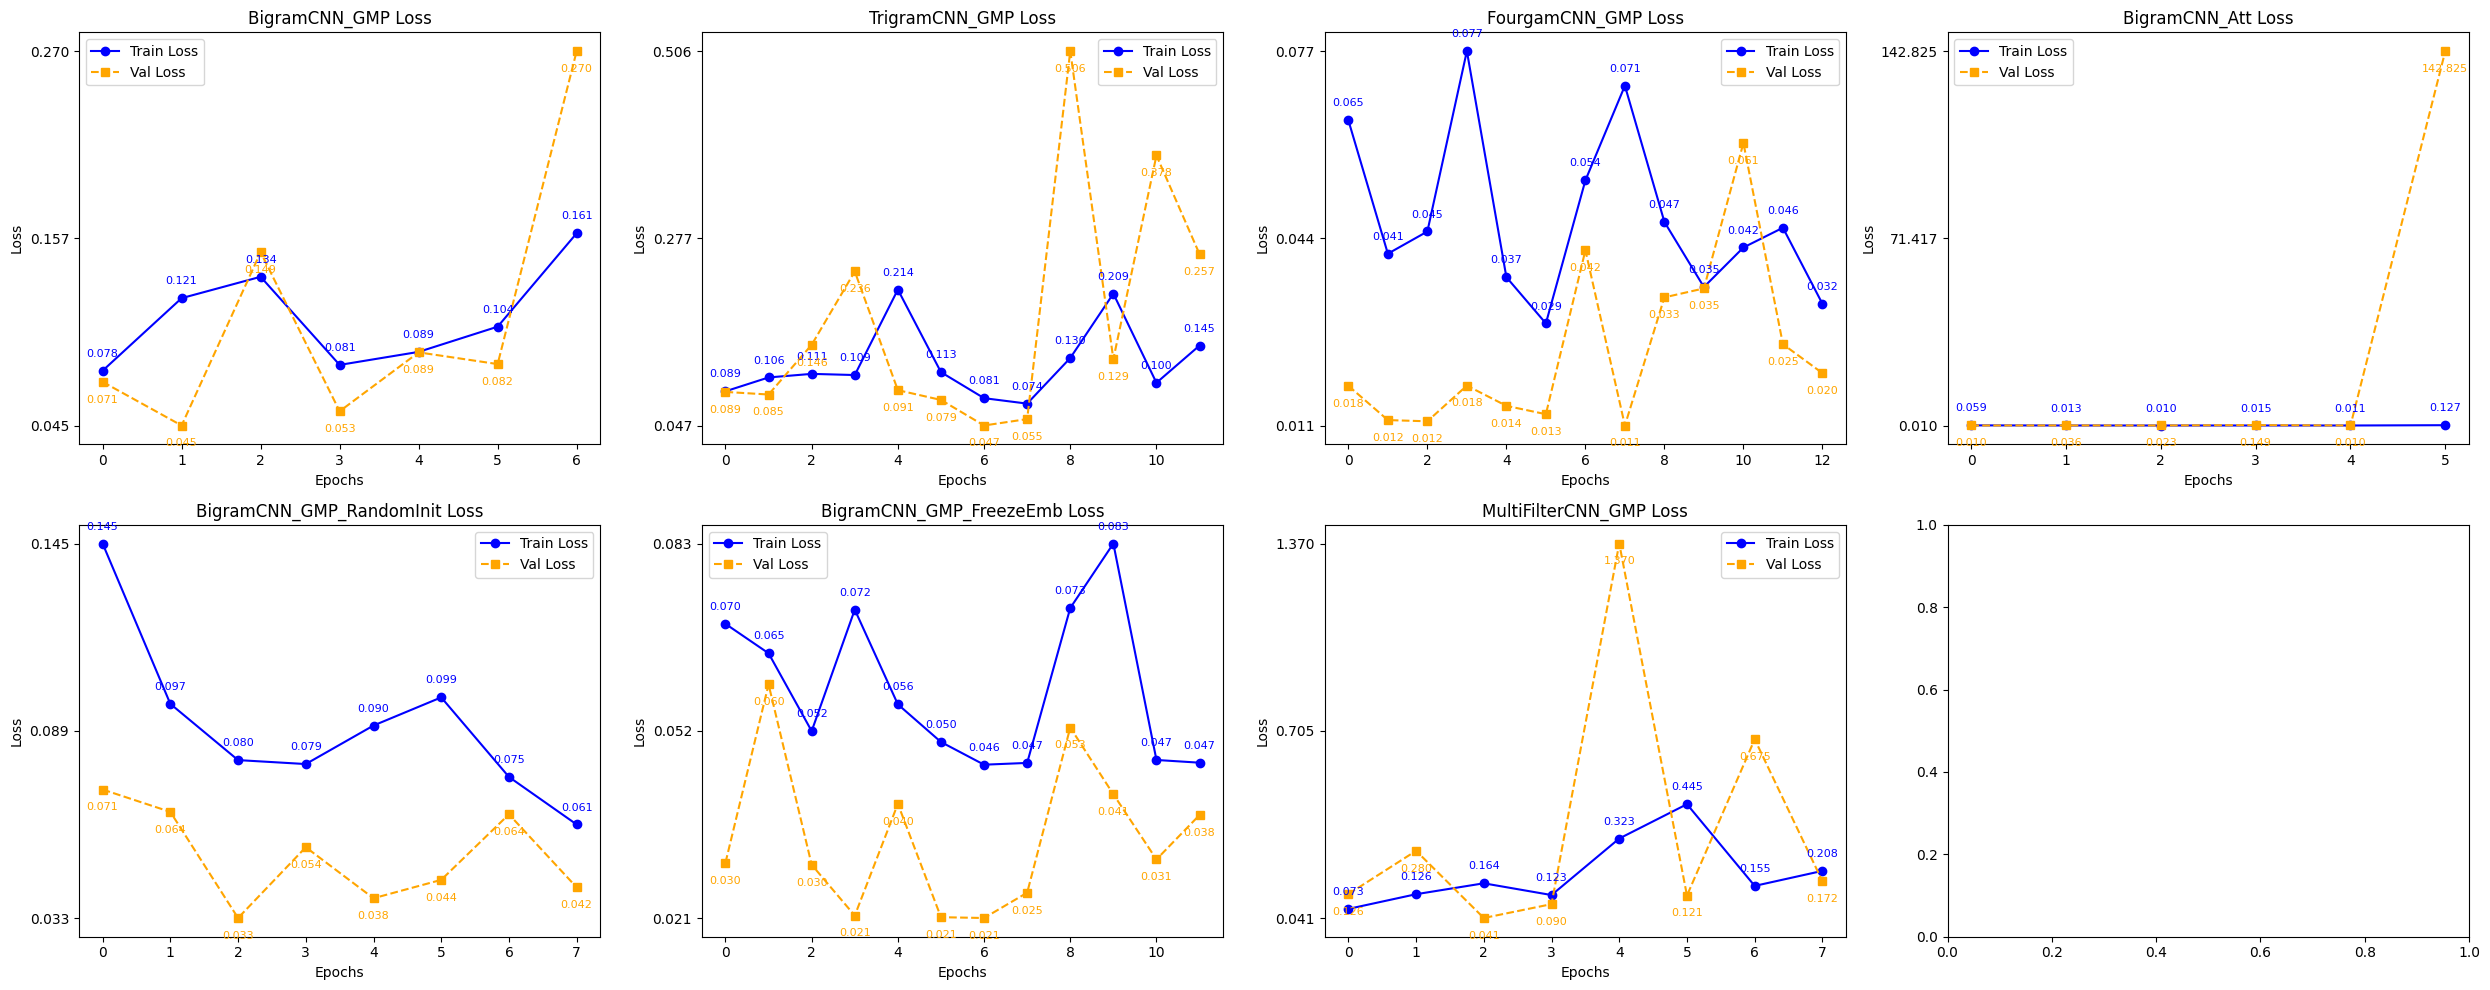

In [ ]:
plot_loss_curves(results)


                      Model  Accuracy_train  Accuracy_val  Accuracy_test  \
0             BigramCNN_GMP            0.99          0.99           0.99   
1            TrigramCNN_GMP            0.96          0.96           0.95   
2            FourgamCNN_GMP            1.00          1.00           1.00   
3             BigramCNN_Att            0.93          0.92           0.92   
4  BigramCNN_GMP_RandomInit            1.00          1.00           0.99   
5   BigramCNN_GMP_FreezeEmb            1.00          1.00           1.00   
6        MultiFilterCNN_GMP            1.00          1.00           1.00   

   Weighted_F1_train  Weighted_F1_val  Weighted_F1_test  PR_AUC_train  \
0               0.99             0.99              0.99      0.994890   
1               0.96             0.96              0.95      0.963607   
2               1.00             1.00              1.00      0.999716   
3               0.93             0.92              0.92      0.967784   
4               1.00      

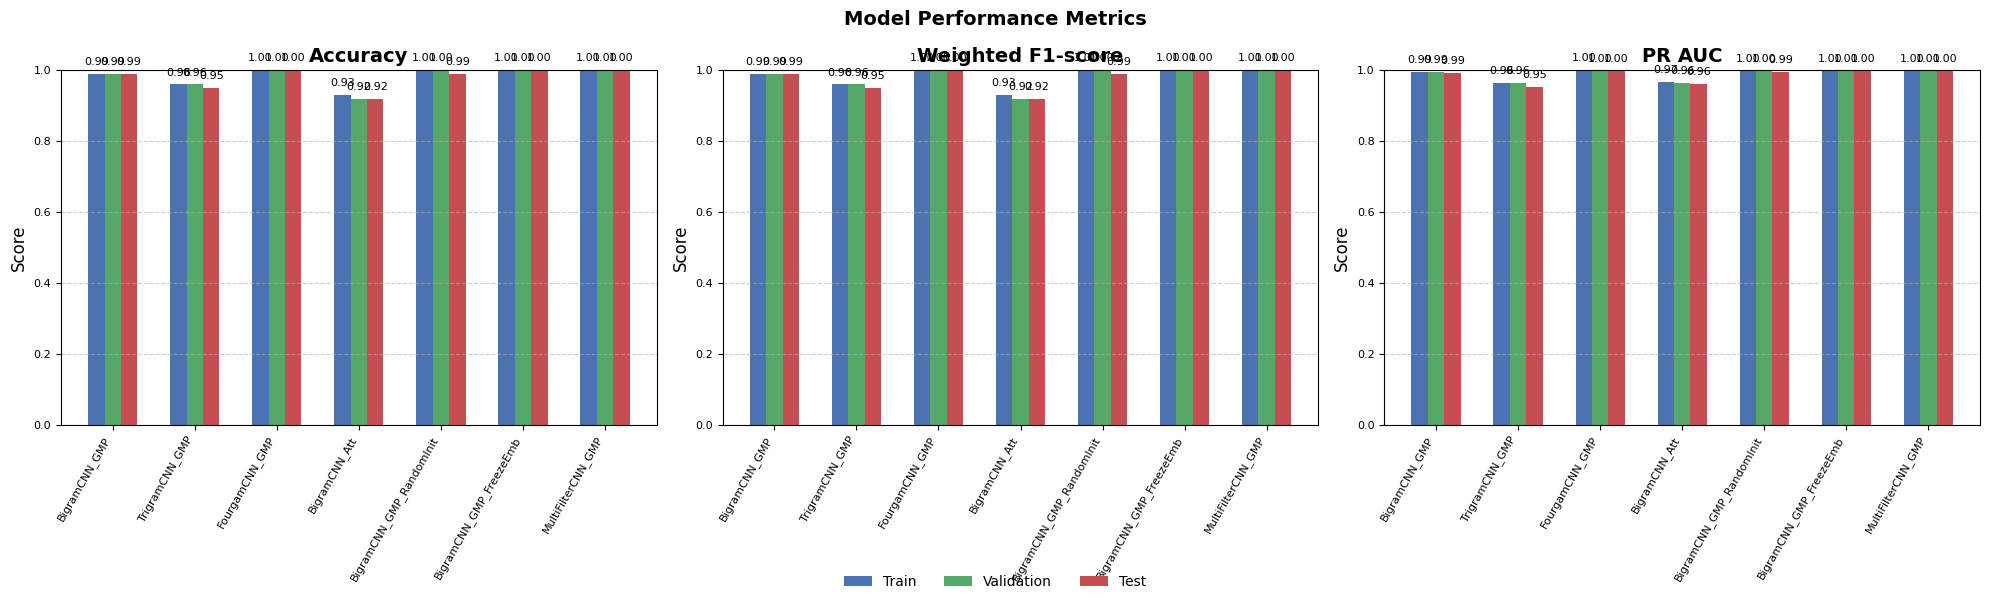

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import re

# Function to extract accuracy and weighted F1-score from classification report
def extract_metrics(report):
    accuracy_match = re.search(r'accuracy\s+([\d\.]+)', report)
    weighted_f1_match = re.search(r'weighted avg\s+[\d\.]+\s+[\d\.]+\s+([\d\.]+)', report)

    accuracy = float(accuracy_match.group(1)) if accuracy_match else None
    weighted_f1 = float(weighted_f1_match.group(1)) if weighted_f1_match else None

    return accuracy, weighted_f1

# Group models by feature representation (TF-IDF, Word2Vec, GloVe)
def plot_performance_metrics(results):
    # Use Seaborn color palette
    sns_colors = sns.color_palette("deep")  # Seaborn deep palette
    colors = [sns_colors[0], sns_colors[2], sns_colors[3]]  # Pick 3 distinct colors

    # Define a set of metrics to plot: accuracy, weighted F1-score, and PR AUC
    metric_data = {
        'Model': [],
        'Accuracy_train': [],
        'Accuracy_val': [],
        'Accuracy_test': [],
        'Weighted_F1_train': [],
        'Weighted_F1_val': [],
        'Weighted_F1_test': [],
        'PR_AUC_train': [],
        'PR_AUC_val': [],
        'PR_AUC_test': [],
    }

    models = list(results.keys())

    # Iterate over each model in the results dictionary
    for model in models:
        metrics = results[model]

        # Extract accuracy and weighted F1 from classification reports
        acc_train, f1_train = extract_metrics(metrics['classification_report_train'][-1])
        acc_val, f1_val = extract_metrics(metrics['classification_report_val'][-1])
        acc_test, f1_test = extract_metrics(metrics['classification_report_test'][-1])

        # Append the metrics to the plot data and DataFrame data
        metric_data['Model'].append(model)
        metric_data['Accuracy_train'].append(acc_train)
        metric_data['Accuracy_val'].append(acc_val)
        metric_data['Accuracy_test'].append(acc_test)

        metric_data['Weighted_F1_train'].append(f1_train)
        metric_data['Weighted_F1_val'].append(f1_val)
        metric_data['Weighted_F1_test'].append(f1_test)

        # Extract PR AUC
        pr_auc_train = metrics['pr_auc_train'][-1]
        pr_auc_val = metrics['pr_auc_val'][-1]
        pr_auc_test = metrics['pr_auc_test'][-1]

        metric_data['PR_AUC_train'].append(pr_auc_train)
        metric_data['PR_AUC_val'].append(pr_auc_val)
        metric_data['PR_AUC_test'].append(pr_auc_test)

    # Create a DataFrame to print the metrics
    df_metrics = pd.DataFrame(metric_data)
    print(df_metrics)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)  # Larger figure size
    fig.suptitle("Model Performance Metrics", fontsize=14, fontweight="bold")

    # Define the labels and data for plotting
    titles = ['Accuracy', 'Weighted F1-score', 'PR AUC']
    data = [
        {'train': metric_data['Accuracy_train'], 'val': metric_data['Accuracy_val'], 'test': metric_data['Accuracy_test']},
        {'train': metric_data['Weighted_F1_train'], 'val': metric_data['Weighted_F1_val'], 'test': metric_data['Weighted_F1_test']},
        {'train': metric_data['PR_AUC_train'], 'val': metric_data['PR_AUC_val'], 'test': metric_data['PR_AUC_test']}
    ]

    # Plot each metric
    for i, (title, metric) in enumerate(zip(titles, data)):
        ax = axes[i]
        x = np.arange(len(models))
        width = 0.2  # Smaller width for spacing

        bars1 = ax.bar(x - width, metric['train'], width, label="Train", color=colors[0])
        bars2 = ax.bar(x, metric['val'], width, label="Validation", color=colors[1])
        bars3 = ax.bar(x + width, metric['test'], width, label="Test", color=colors[2])

        # Add value labels on bars
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 5),  # Offset for visibility
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=8)  # Smaller font size for annotations

        # Set labels and formatting
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=60, ha="right", fontsize=10)  # Smaller font size for x labels
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel("Score", fontsize=12)
        ax.set_ylim(0, 1)  # Ensures consistent scaling
        ax.grid(axis='y', linestyle='--', alpha=0.6)

        # Adjust tick size
        ax.tick_params(axis='both', which='major', labelsize=8)  # Smaller tick marks

    # Add a single legend for the whole row
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=10, frameon=False)

    plt.subplots_adjust(bottom=0.3, top=0.85)
    plt.tight_layout()
    plt.show()

# Assuming the results dictionary is populated, call the function
plot_performance_metrics(results)


##Baseline Dummy and Wide MLP

# Model Performance Report

## **Bigram, Trigram, and Fourgram CNN Models:**

### 1. **BigramCNN_GMP**
- **Accuracy (Train/Val/Test):** 0.99 / 0.99 / 0.99
- **Weighted F1 (Train/Val/Test):** 0.99 / 0.99 / 0.99
- **PR AUC (Train/Val/Test):** 0.994890 / 0.994841 / 0.992858

### 2. **TrigramCNN_GMP**
- **Accuracy (Train/Val/Test):** 0.96 / 0.96 / 0.95
- **Weighted F1 (Train/Val/Test):** 0.96 / 0.96 / 0.95
- **PR AUC (Train/Val/Test):** 0.963607 / 0.963684 / 0.953681

### 3. **FourgramCNN_GMP**
- **Accuracy (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **Weighted F1 (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **PR AUC (Train/Val/Test):** 0.999716 / 0.999075 / 0.998070

### 4. **BigramCNN_Att**
- **Accuracy (Train/Val/Test):** 0.93 / 0.92 / 0.92
- **Weighted F1 (Train/Val/Test):** 0.93 / 0.92 / 0.92
- **PR AUC (Train/Val/Test):** 0.967784 / 0.963834 / 0.962311

### 5. **BigramCNN_GMP_RandomInit**
- **Accuracy (Train/Val/Test):** 1.00 / 1.00 / 0.99
- **Weighted F1 (Train/Val/Test):** 1.00 / 1.00 / 0.99
- **PR AUC (Train/Val/Test):** 0.997904 / 0.996964 / 0.994864

### 6. **BigramCNN_GMP_FreezeEmb**
- **Accuracy (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **Weighted F1 (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **PR AUC (Train/Val/Test):** 0.998058 / 0.997704 / 0.997296

### 7. **MultiFilterCNN_GMP**
- **Accuracy (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **Weighted F1 (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **PR AUC (Train/Val/Test):** 0.999606 / 0.998946 / 0.998207

---

## **RNN, GRU, and LSTM Models:**

### 1. **RNN**
- **Accuracy (Train/Val/Test):** 0.81 / 0.79 / 0.80
- **Weighted F1 (Train/Val/Test):** 0.81 / 0.79 / 0.80
- **PR AUC (Train/Val/Test):** 0.894212 / 0.878705 / 0.877910

### 2. **GRU**
- **Accuracy (Train/Val/Test):** 0.95 / 0.94 / 0.94
- **Weighted F1 (Train/Val/Test):** 0.95 / 0.94 / 0.94
- **PR AUC (Train/Val/Test):** 0.969749 / 0.963957 / 0.962466

### 3. **LSTM**
- **Accuracy (Train/Val/Test):** 0.91 / 0.90 / 0.90
- **Weighted F1 (Train/Val/Test):** 0.91 / 0.90 / 0.90
- **PR AUC (Train/Val/Test):** 0.946631 / 0.932909 / 0.933250

### 4. **LSTM_GMP**
- **Accuracy (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **Weighted F1 (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **PR AUC (Train/Val/Test):** 0.999973 / 0.999362 / 0.998946

### 5. **RandomInit**
- **Accuracy (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **Weighted F1 (Train/Val/Test):** 1.00 / 1.00 / 1.00
- **PR AUC (Train/Val/Test):** 0.999277 / 0.998853 / 0.998003

---

## **Best Performing Models:**

### **Top Model (Based on Accuracy, F1 Score, and PR AUC):**
- **FourgramCNN_GMP** is the best-performing model with:
  - **Perfect accuracy** across all sets (Train/Val/Test = 1.00).
  - **Weighted F1 score of 1.00** for Train/Val/Test.
  - **PR AUC**: 0.999716 (Train), 0.999075 (Val), 0.998070 (Test).
  
### **Top RNN Model:**
- **LSTM_GMP** stands out with:
  - **Perfect accuracy** across all sets (Train/Val/Test = 1.00).
  - **Weighted F1 score of 1.00** for Train/Val/Test.
  - **PR AUC**: 0.999973 (Train), 0.999362 (Val), 0.998946 (Test).

---

## **Conclusion:**
For this task, **FourgramCNN_GMP** and **LSTM_GMP** offer the best performance, with both models achieving perfect accuracy, weighted F1 scores, and strong PR AUC values across all datasets (train, validation, and test). The **FourgramCNN_GMP** model excels particularly in CNN-based approaches, while **LSTM_GMP** delivers impressive results with the RNN architecture.


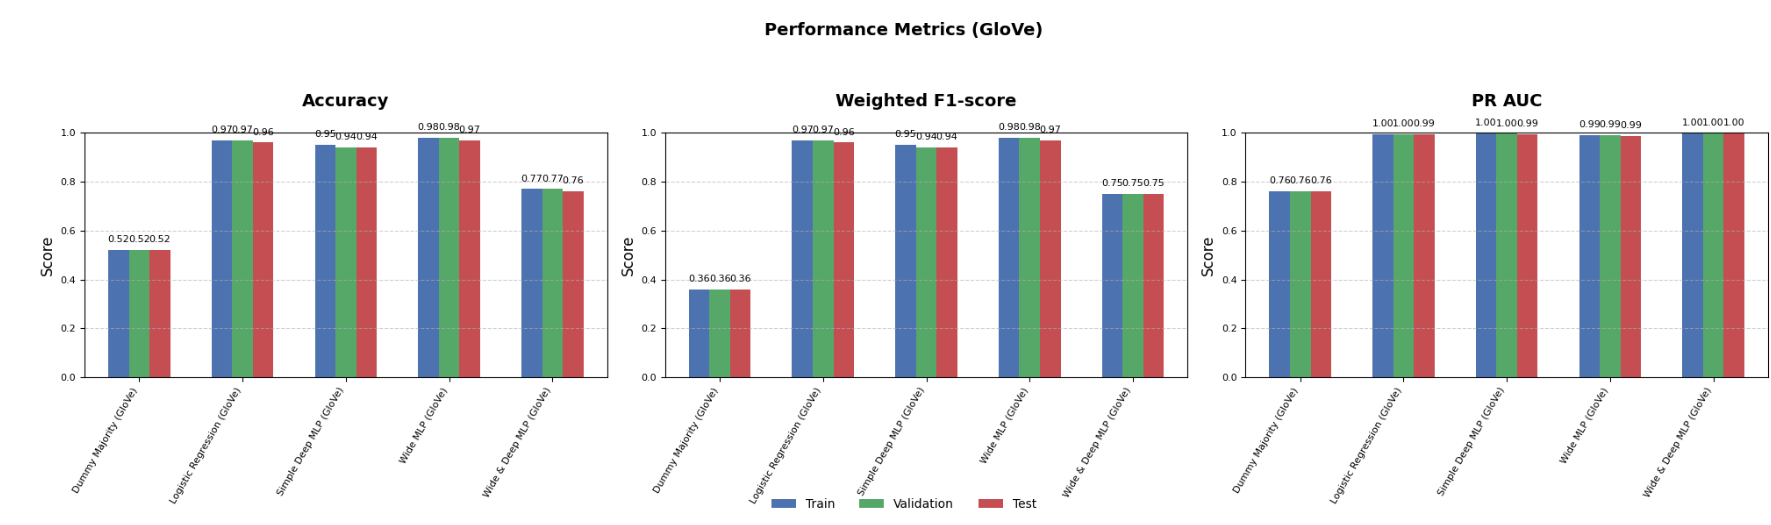

# Exercise 3


Repeat Exercise 2 of Part 4 (NLP with RNNs), now using a stacked CNN with n-gram
filters (e.g., 𝑛 = 2, 3, 4), residual connections, and a dense layer (the same at all word
positions) with softmax at the top layer, implemented in PyTorch.

1. Tune the hyper-parameters (e.g., values of 𝑛, number of
stacked convolutional layers) on the development subset of the dataset. Monitor the
performance of your models on the development subset during training to decide how many
epochs to use. You may optionally add a character-level CNN to produce word embeddings
from characters, concatenating each resulting character-based word embedding with the
corresponding pre-trained word embedding (e.g., obtained with Word2Vec).

2. Include
experimental results of a baseline that tags each word with the most frequent tag it had in the
training data; for words that were not encountered in the training data, the baseline should
return the most frequent tag (over all words) of the training data. Also include experimental
results of your best method from exercise 10 of Part 3 and exercise 2 of Part 4.

3. Otherwise, the
contents of your report should be as in exercise 2 of Part 4, but now with information and
results for the experiments of this exercise. You may optionally wish to try ensembles.

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import requests
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from collections import defaultdict, Counter

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Download

In [ ]:
# URLs for the train, dev, and test data
urls = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"
}

# Function to download data from URLs
def download_data(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
        return

    try:
        print(f"Downloading {filename}...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Downloaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")

# Download train, dev, and test data
download_data(urls['train'], 'en_ewt-ud-train.conllu')
download_data(urls['dev'], 'en_ewt-ud-dev.conllu')
download_data(urls['test'], 'en_ewt-ud-test.conllu')


Downloaded en_ewt-ud-train.conllu
Downloaded en_ewt-ud-dev.conllu
Downloaded en_ewt-ud-test.conllu


## Data Parsing and Preprocessing

In [ ]:
def parse_conllu_file(filename):
    """
    Parse a .conllu file to extract words and their POS tags.
    Returns a list of sentences, where each sentence is a list of tuples (word, pos_tag).
    """
    sentences = []
    sentence = []

    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # Skip empty lines and comments
            if line.strip() == "" or line.startswith("#"):
                continue

            # Split each line into columns (word, pos_tag, etc.)
            columns = line.strip().split("\t")
            word = columns[1]
            pos_tag = columns[3]

            sentence.append((word, pos_tag))

            # Check if we reached the end of a sentence (a line with only space or empty)
            if len(columns) == 1:
                if sentence:
                    sentences.append(sentence)
                sentence = []

    # In case the last sentence doesn't have an empty line at the end
    if sentence:
        sentences.append(sentence)

    return sentences


train_data = parse_conllu_file('en_ewt-ud-train.conllu')
dev_data = parse_conllu_file('en_ewt-ud-dev.conllu')
test_data = parse_conllu_file('en_ewt-ud-test.conllu')

In [ ]:
def extract_context_windows(sentences, word2vec_model, window_size=3):
    data = []
    for sentence in sentences:
        # Loop over each word in the sentence, using it as the target word
        for i, (word, pos_tag) in enumerate(sentence):
            # Create a context window of size 3
            context = []
            for j in range(-window_size, window_size + 1):
                if i + j >= 0 and i + j < len(sentence) and j != 0:
                    context.append(sentence[i + j][0])  # Add context word (excluding the target word)

            # Convert the context words to embeddings (Word2Vec)
            context_embeddings = []
            for context_word in context:
                if context_word in word2vec_model:
                    context_embeddings.append(word2vec_model[context_word])
                else:
                    context_embeddings.append(np.zeros(word2vec_model.vector_size))  # For unknown words

            # Aggregate context embeddings into a single vector (average of all context word embeddings)
            context_vector = np.mean(context_embeddings, axis=0)  # Averaging the context words' embeddings
            target_word_embedding = word2vec_model[word] if word in word2vec_model else np.zeros(word2vec_model.vector_size)

            # Combine the context and target word embeddings into one feature vector
            feature_vector = np.concatenate([context_vector, target_word_embedding])

            # Append the feature vector along with the corresponding POS tag
            data.append((feature_vector, pos_tag))

    return data



# Load the pre-trained Word2Vec model (using the example from gensim)
import gensim.downloader as api
word2vec = api.load("word2vec-google-news-300")  # 300-dimensional Word2Vec embeddings

# Extract training, dev, and test data
train_features = extract_context_windows(train_data, word2vec)
dev_features = extract_context_windows(dev_data, word2vec)
test_features = extract_context_windows(test_data, word2vec)


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Prepare the data
def prepare_data(features, window_size=3):
    # Extract feature vectors and labels
    X = [f[0] for f in features]
    y = [f[1] for f in features]

    # Convert feature vectors into tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # The size of each feature vector should be (300 * window_size * 2 + 300)
    # Reshape X_tensor to have shape (batch_size, channels, seq_len)
    # Note: seq_len should be the length of the sentence (we need to reshape appropriately for CNN)

    # So the shape should be (batch_size, channels=300, seq_len) where seq_len is the number of words in the sentence

    # Reshaping to match CNN input (batch_size, channels, seq_len)
    X_tensor = X_tensor.view(len(X_tensor), 300, -1)  # This assumes each feature vector's second dimension is 300.

    # Encode POS tags as integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y_tensor = torch.tensor(y_encoded, dtype=torch.long)

    return TensorDataset(X_tensor, y_tensor)


# Prepare the datasets for training, dev, and test
train_dataset = prepare_data(train_features)
dev_dataset = prepare_data(dev_features)
test_dataset = prepare_data(test_features)

# Create DataLoader for batching
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Get the unique POS tags from the training data
pos_tags = list(set([tag for _, tag in train_features]))
pos_tags.sort()  # Sort for a consistent order

# Create a dictionary that maps index to POS tag
tag_to_idx = {pos_tags[i]: i for i in range(len(pos_tags))}
idx_to_tag = {i: pos_tags[i] for i in range(len(pos_tags))}


## CNNs Architecture, Training and Evaluation

In [ ]:
class ShallowPOS_CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, kernel_size=3, num_filters=64, dropout=0.3):
        super(ShallowPOS_CNN, self).__init__()

        # Convolutional layers (1D)
        self.conv1 = nn.Conv1d(input_dim, num_filters, kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(num_filters, num_filters, kernel_size, padding=kernel_size//2)

        # Max pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected output layer
        self.fc = nn.Linear(num_filters, output_dim)

        # ReLU activation
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convert input to (batch_size, channels, seq_len) for 1D convolution
        x = x.permute(0, 2, 1)

        # Pass input through first convolutional layer
        x = self.relu(self.conv1(x))
        x = self.dropout(x)

        # Pass through second convolutional layer
        x = self.relu(self.conv2(x))
        x = self.dropout(x)

        # Max pooling
        x = self.pool(x)

        # Flatten the output (batch_size, num_filters * seq_len)
        x = x.view(x.size(0), -1)

        # Fully connected layer to get the output
        out = self.fc(x)

        return out


In [ ]:
class DeepPOS_CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(DeepPOS_CNN, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Reshape the input tensor to (batch_size, channels, seq_len)
        x = x.transpose(1, 2)  # Transpose from (batch_size, seq_len, feature_size) to (batch_size, feature_size, seq_len)

        # Apply convolution layers with ReLU activation
        x = self.conv1(x)
        x = F.relu(x)

        # Apply global average pooling (GAP)
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        x = self.conv2(x)
        x = F.relu(x)

        # Apply global average pooling again
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        # Flatten the output to feed into the fully connected layer
        x = x.view(x.size(0), -1)

        # Apply dropout for regularization
        x = self.dropout(x)

        # Output layer
        x = self.fc(x)

        return x


In [ ]:
class VeryDeepPOS_CNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(VeryDeepPOS_CNN, self).__init__()

        # Define convolutional layers (deep model)
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Reshape the input tensor to (batch_size, channels, seq_len)
        x = x.transpose(1, 2)  # Transpose from (batch_size, seq_len, feature_size) to (batch_size, feature_size, seq_len)

        # Apply convolution layers with ReLU activation
        x = self.conv1(x)
        x = F.relu(x)

        # Apply global average pooling (GAP)
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        x = self.conv2(x)
        x = F.relu(x)

        # Apply global average pooling again
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        x = self.conv3(x)
        x = F.relu(x)

        # Apply global average pooling again
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        x = self.conv4(x)
        x = F.relu(x)

        # Apply global average pooling again
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        x = self.conv5(x)
        x = F.relu(x)

        # Apply global average pooling one more time
        x = F.adaptive_avg_pool1d(x, 1)  # This will reduce the sequence length to 1 for each channel

        # Flatten the output to feed into the fully connected layer
        x = x.view(x.size(0), -1)

        # Apply dropout for regularization
        x = self.dropout(x)

        # Output layer
        x = self.fc(x)

        return x


In [ ]:
def train_and_evaluate_cnn(model_class, input_dim, hidden_dim, output_dim, num_epochs=20):
    # Initialize the model
    model = model_class(input_dim, hidden_dim, output_dim, dropout=0.5).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Scheduler to adjust learning rate

    train_losses = []
    dev_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        for inputs, labels in train_loader:
            # Convert input shape from (batch_size, seq_len, input_dim) to (batch_size, input_dim, seq_len)
            inputs = inputs.permute(0, 2, 1).to(device)  # Change shape to (batch_size, input_dim, seq_len)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass through the model (CNN)
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels.to(device))  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))  # Average loss per batch
        scheduler.step()  # Update learning rate

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_dev_loss = 0
        with torch.no_grad():  # No need for gradients during validation
            for inputs, labels in dev_loader:
                inputs = inputs.permute(0, 2, 1).to(device)  # Convert input shape for CNN
                outputs = model(inputs)
                loss = criterion(outputs, labels.to(device))
                total_dev_loss += loss.item()

        dev_losses.append(total_dev_loss / len(dev_loader))  # Average loss per batch

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_train_loss / len(train_loader)}, Dev Loss: {total_dev_loss / len(dev_loader)}")

    # Plotting training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='#00008B')
    plt.plot(range(1, num_epochs+1), dev_losses, label="Dev Loss", linestyle='--', color='#00008B')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Evaluate on the test set
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []  # To store the predicted probabilities

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.permute(0, 2, 1).to(device)  # Convert input shape for CNN
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(predicted.numpy())
            y_prob.extend(torch.softmax(outputs, dim=1).cpu().numpy())  # Get probabilities

    # Convert numeric labels to POS tags using idx_to_tag
    y_true_tags = [idx_to_tag[idx] for idx in y_true]
    y_pred_tags = [idx_to_tag[idx] for idx in y_pred]

    # Classification report with tags instead of numeric class labels
    print(f"Classification Report for {model_class.__name__}:")
    print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

    # Calculate AUC scores for each class
    auc_scores = {}
    for i, tag in enumerate(pos_tags):
        # One-hot encode the true labels for the current tag
        true_binary = [1 if label == i else 0 for label in y_true]
        pred_prob = [prob[i] for prob in y_prob]  # Probabilities for the current tag

        auc_score = roc_auc_score(true_binary, pred_prob)
        auc_scores[tag] = auc_score

    # Print AUC scores for each class
    print("\nAUC Scores for Each Class:")
    for tag, auc in auc_scores.items():
        print(f"{tag}: {auc:.4f}")

    # Calculate Macro-Averaged Precision, Recall, F1, and Precision-Recall AUC
    # Precision, recall, and F1
    report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=0)
    precision_macro = report["macro avg"]["precision"]
    recall_macro = report["macro avg"]["recall"]
    f1_macro = report["macro avg"]["f1-score"]

    # Precision-Recall AUC (macro-average)
    precision_recall_auc_macro = np.mean([roc_auc_score([1 if label == i else 0 for label in y_true],
                                                       [prob[i] for prob in y_prob]) for i in range(len(pos_tags))])

    # Print Macro-Averaged Metrics
    print(f"\nMacro-Averaged Precision: {precision_macro}")
    print(f"Macro-Averaged Recall: {recall_macro}")
    print(f"Macro-Averaged F1: {f1_macro}")
    print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro}")

    return model


In [ ]:
# Set device (you can change this to 'cuda' if you're using a GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
input_dim = 300  # Example, change as needed
hidden_dim = 128  # Example, change as needed
output_dim = len(pos_tags)  # Number of POS tags
num_epochs = 20  # Number of epochs for training

Training Shallow Model...
Epoch 1/20, Train Loss: 0.8446043420806205, Dev Loss: 0.6747861500820121
Epoch 2/20, Train Loss: 0.6442228303399625, Dev Loss: 0.6320350958888692
Epoch 3/20, Train Loss: 0.6127089372823973, Dev Loss: 0.6071083510952785
Epoch 4/20, Train Loss: 0.5947239903009476, Dev Loss: 0.5932203148092542
Epoch 5/20, Train Loss: 0.5843368412039764, Dev Loss: 0.5793033811009318
Epoch 6/20, Train Loss: 0.5743238648987612, Dev Loss: 0.5818347755380741
Epoch 7/20, Train Loss: 0.5686665016046418, Dev Loss: 0.569803922248066
Epoch 8/20, Train Loss: 0.5632487145138052, Dev Loss: 0.5633781988519176
Epoch 9/20, Train Loss: 0.557556352092021, Dev Loss: 0.5623411786063273
Epoch 10/20, Train Loss: 0.5547042744967067, Dev Loss: 0.5628197851933932
Epoch 11/20, Train Loss: 0.5326905837898052, Dev Loss: 0.5541053697429504
Epoch 12/20, Train Loss: 0.5267434754835153, Dev Loss: 0.5519880513873017
Epoch 13/20, Train Loss: 0.5211678501851328, Dev Loss: 0.5497303476608487
Epoch 14/20, Train Loss

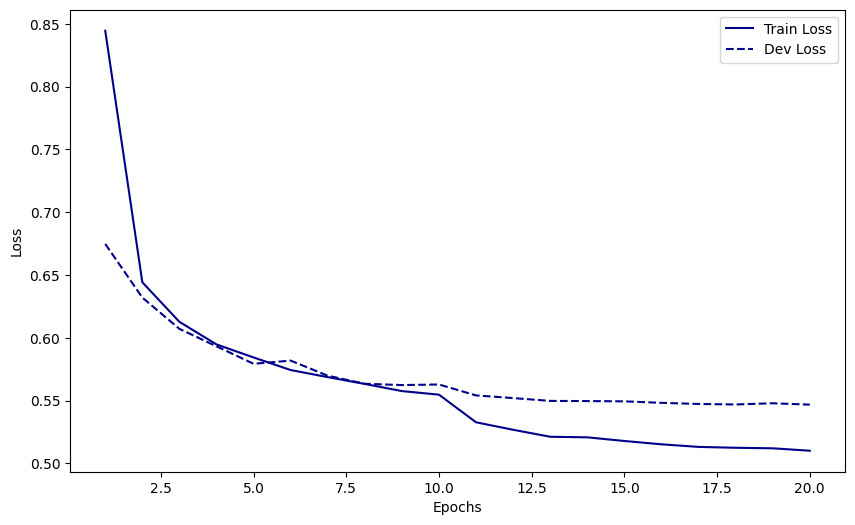

Classification Report for ShallowPOS_CNN:
              precision    recall  f1-score   support

         ADJ       0.90      0.90      0.90      1794
         ADP       0.85      0.73      0.78      2030
         ADV       0.93      0.84      0.89      1183
         AUX       0.97      0.95      0.96      1543
       CCONJ       0.98      0.27      0.43       736
         DET       0.94      0.74      0.83      1896
        INTJ       0.94      0.70      0.81       121
        NOUN       0.89      0.90      0.89      4123
         NUM       0.76      0.36      0.49       542
        PART       0.79      0.50      0.62       649
        PRON       0.97      0.97      0.97      2166
       PROPN       0.90      0.78      0.84      2076
       PUNCT       0.54      0.98      0.70      3096
       SCONJ       0.82      0.57      0.68       384
         SYM       0.98      0.59      0.74       109
        VERB       0.93      0.90      0.91      2606
           X       0.00      0.00      

In [ ]:
# Shallow Model - Train
print("Training Shallow Model...")
shallow_model = train_and_evaluate_cnn(ShallowPOS_CNN, input_dim, hidden_dim, output_dim, num_epochs=num_epochs)


Training Deep Model...
Epoch 1/20, Train Loss: 0.7736386407610809, Dev Loss: 0.597489666445811
Epoch 2/20, Train Loss: 0.5725546782448603, Dev Loss: 0.5690608834264272
Epoch 3/20, Train Loss: 0.5249782080236889, Dev Loss: 0.5467145647246736
Epoch 4/20, Train Loss: 0.49549732145573194, Dev Loss: 0.5400558091270595
Epoch 5/20, Train Loss: 0.4692995683131872, Dev Loss: 0.5387196674905624
Epoch 6/20, Train Loss: 0.4486944978530942, Dev Loss: 0.5454042985251075
Epoch 7/20, Train Loss: 0.42938716755633444, Dev Loss: 0.5393703370763544
Epoch 8/20, Train Loss: 0.4140540090302688, Dev Loss: 0.5509671523308096
Epoch 9/20, Train Loss: 0.3992549410668548, Dev Loss: 0.5568088631059293
Epoch 10/20, Train Loss: 0.3849147849516636, Dev Loss: 0.5755845048000341
Epoch 11/20, Train Loss: 0.3450388986435549, Dev Loss: 0.5812750504653257
Epoch 12/20, Train Loss: 0.33531700747249815, Dev Loss: 0.5847260800369999
Epoch 13/20, Train Loss: 0.3299435027371666, Dev Loss: 0.5914308030653119
Epoch 14/20, Train Lo

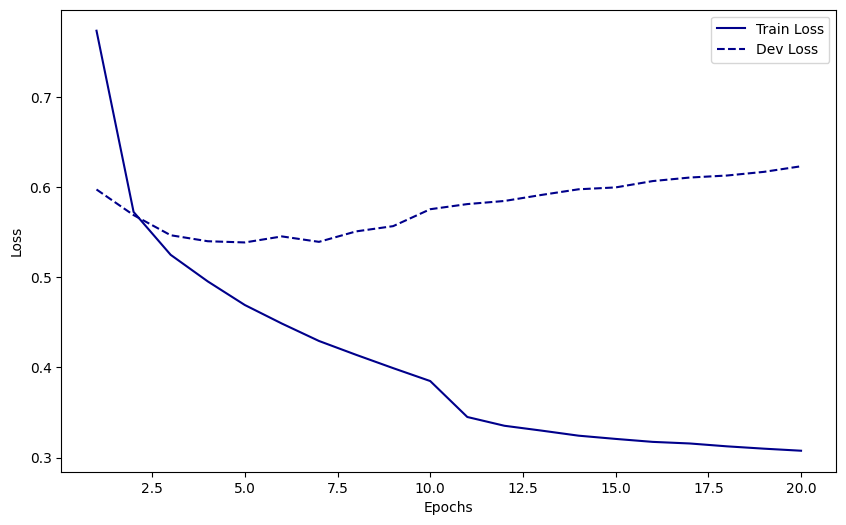

Classification Report for DeepPOS_CNN:
              precision    recall  f1-score   support

         ADJ       0.91      0.88      0.90      1794
         ADP       0.81      0.77      0.79      2030
         ADV       0.90      0.87      0.88      1183
         AUX       0.96      0.97      0.96      1543
       CCONJ       0.68      0.36      0.47       736
         DET       0.86      0.80      0.83      1896
        INTJ       0.93      0.76      0.84       121
        NOUN       0.90      0.89      0.90      4123
         NUM       0.62      0.53      0.57       542
        PART       0.61      0.66      0.64       649
        PRON       0.96      0.97      0.97      2166
       PROPN       0.89      0.80      0.84      2076
       PUNCT       0.61      0.85      0.71      3096
       SCONJ       0.77      0.71      0.74       384
         SYM       0.96      0.61      0.74       109
        VERB       0.92      0.91      0.92      2606
           X       0.00      0.00      0.0

In [ ]:
# Deep Model - Train
print("\nTraining Deep Model...")
deep_model = train_and_evaluate_cnn(DeepPOS_CNN, input_dim, hidden_dim, output_dim, num_epochs=num_epochs)


Training Very Deep Model...
Epoch 1/20, Train Loss: 0.9364304318701948, Dev Loss: 0.6795115483583962
Epoch 2/20, Train Loss: 0.6265663460789822, Dev Loss: 0.6250142339701042
Epoch 3/20, Train Loss: 0.5670794998194937, Dev Loss: 0.6160516358333123
Epoch 4/20, Train Loss: 0.5285368002882116, Dev Loss: 0.6172162003086922
Epoch 5/20, Train Loss: 0.4992443193313956, Dev Loss: 0.597215403590286
Epoch 6/20, Train Loss: 0.4755320267048863, Dev Loss: 0.6029499950713681
Epoch 7/20, Train Loss: 0.45397160375068557, Dev Loss: 0.618910239677979
Epoch 8/20, Train Loss: 0.43597622876359843, Dev Loss: 0.6384463466349102
Epoch 9/20, Train Loss: 0.4180797252060824, Dev Loss: 0.6537254436273026
Epoch 10/20, Train Loss: 0.40524341181205925, Dev Loss: 0.6540592374807611
Epoch 11/20, Train Loss: 0.34633021131894187, Dev Loss: 0.7051294672683367
Epoch 12/20, Train Loss: 0.32709902633094284, Dev Loss: 0.7409660087566925
Epoch 13/20, Train Loss: 0.3170138965507508, Dev Loss: 0.7645145130710196
Epoch 14/20, Tr

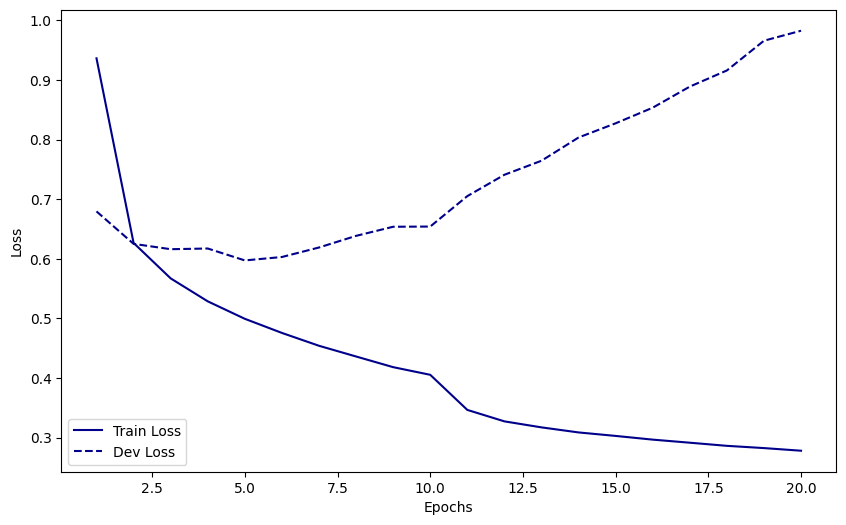

Classification Report for VeryDeepPOS_CNN:
              precision    recall  f1-score   support

         ADJ       0.89      0.88      0.89      1794
         ADP       0.80      0.74      0.77      2030
         ADV       0.89      0.87      0.88      1183
         AUX       0.96      0.96      0.96      1543
       CCONJ       0.59      0.36      0.45       736
         DET       0.82      0.80      0.81      1896
        INTJ       0.89      0.69      0.78       121
        NOUN       0.89      0.88      0.89      4123
         NUM       0.55      0.44      0.49       542
        PART       0.59      0.63      0.61       649
        PRON       0.97      0.97      0.97      2166
       PROPN       0.89      0.79      0.84      2076
       PUNCT       0.59      0.79      0.68      3096
       SCONJ       0.78      0.67      0.72       384
         SYM       0.93      0.61      0.74       109
        VERB       0.90      0.91      0.91      2606
           X       0.00      0.00     

In [ ]:
# Very Deep Model - Train
print("\nTraining Very Deep Model...")
very_deep_model = train_and_evaluate_cnn(VeryDeepPOS_CNN, input_dim, hidden_dim, output_dim, num_epochs=num_epochs)

## Choice of Architectures for Shallow, Somewhat Deep, and Deep CNNs

### 1. Shallow CNN (ShallowPOS_CNN)

The **Shallow CNN** is designed to be a relatively simple model with only two convolutional layers. This architecture is useful when the input data does not require too much feature extraction complexity, or when computational efficiency is a priority.

### Architecture Details:
- **Convolutional Layers**:
  - **Conv1**: The first convolutional layer applies 64 filters of size 3, with zero-padding to preserve sequence length. This helps capture local features from the input sequences.
  - **Conv2**: The second convolutional layer applies the same number of filters (64) with the same kernel size (3).
  
- **Max Pooling**:
  - A **max pooling** layer with a kernel size of 2 is applied after the convolutional layers. Pooling reduces the dimensionality of the feature maps, which helps prevent overfitting and reduces the computational load.

- **Dropout**:
  - A dropout layer with a probability of 0.3 is used after each convolutional layer to regularize the model and prevent overfitting.

- **Fully Connected Layer**:
  - The final output of the model is produced by a fully connected layer, which maps the learned features to the output space (POS tags).

### Why this architecture?
- **Shallow**: The model only uses two convolutional layers, making it lightweight and computationally efficient.
- **Local Features**: It focuses on learning local features via small kernels.
- **Regularization**: The use of dropout helps to generalize the model despite its simplicity.

---

### 2. Somewhat Deep CNN (DeepPOS_CNN)

The **Somewhat Deep CNN** is a deeper model that uses two convolutional layers, followed by **global average pooling (GAP)** instead of max pooling. GAP helps reduce overfitting by summarizing feature maps in a compact way.

### Architecture Details:
- **Convolutional Layers**:
  - **Conv1**: The first convolutional layer applies `hidden_dim` filters with a kernel size of 3, which allows the model to learn low-level features from the input data.
  - **Conv2**: The second convolutional layer uses the same number of filters (`hidden_dim`), deepening the feature extraction process.
  
- **Global Average Pooling**:
  - Instead of using max pooling, this model applies **global average pooling (GAP)** after each convolutional layer. GAP reduces each feature map to a single value, which encourages the model to focus on global patterns rather than local ones.
  
- **Dropout**:
  - Dropout (0.3) is applied after the GAP layers and before the fully connected layer to further reduce overfitting.

- **Fully Connected Layer**:
  - A fully connected layer is used to produce the final predictions, reducing the feature maps to the target output dimension.

### Why this architecture?
- **Deeper Learning**: The addition of global average pooling allows the model to capture more abstract features and learn global patterns from the data.
- **GAP Regularization**: GAP prevents the model from overfitting by focusing on the global structure of the feature maps instead of local patterns.

---

### 3. Very Deep CNN (VeryDeepPOS_CNN)

The **Very Deep CNN** is the most complex model with five convolutional layers, followed by **global average pooling**. This architecture aims to extract hierarchical and abstract features from the input sequence by passing it through multiple layers of convolutions and pooling.

### Architecture Details:
- **Convolutional Layers**:
  - This model uses **five convolutional layers** with a kernel size of 3 and padding of 1, which enables the model to learn increasingly abstract features at different levels of depth.
  - Each convolutional layer uses `hidden_dim` filters, which gradually capture more complex patterns in the data.

- **Global Average Pooling**:
  - After each convolutional layer, **global average pooling (GAP)** is applied. This operation reduces the sequence length to 1 for each feature map, effectively condensing the learned features into a more compact representation.

- **Dropout**:
  - Dropout (0.3) is applied after the final pooling operation to help reduce overfitting and improve generalization.

- **Fully Connected Layer**:
  - A fully connected output layer is used to map the learned features to the target output (POS tags).

### Why this architecture?
- **Very Deep Learning**: With five convolutional layers, this model is able to extract highly abstract and hierarchical features from the input data.
- **Hierarchical Feature Extraction**: By stacking several layers, the model can detect progressively complex patterns from local to global representations.
- **Robust Generalization**: The use of GAP and dropout ensures that the model generalizes well despite its depth, preventing overfitting.

---

### Conclusion:
- **Shallow CNN**: Simple and efficient, focuses on local features with fewer convolutional layers and max pooling.
- **Somewhat Deep CNN**: Deeper than the shallow model, using global average pooling and dropout for regularization, capable of learning more abstract features.
- **Very Deep CNN**: A highly expressive model with five convolutional layers, ideal for capturing complex hierarchical features, balanced with global average pooling and dropout for regularization.

## Comparison Board

| **Model**                | **Accuracy** | **Macro avg F1-score** | **Weighted avg F1-score** | **Strengths**                                                                                                                                     | **Weaknesses**                                                                                                             |
|--------------------------|--------------|------------------------|---------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------|
| **ShallowPOS_MLP**        | 0.83         | 0.74                   | 0.83                      | High performance on **PRON (0.97 precision)**, **AUX (0.96 recall)**, and **VERB (0.91 f1-score)**.                                               | Struggles with **X (f1 = 0.00)** and **CCONJ (0.45 f1)**.                                                                |
| **DeepPOS_MLP**          | 0.83         | 0.74                   | 0.83                      | Improved recall for **AUX (0.94)** and **PRON (0.97)**, maintains strong performance across categories.                                           | Struggles with rare categories like **X**.                                                                                 |
| **VeryDeepPOS_MLP**      | 0.82         | 0.74                   | 0.82                      | Strong performance on **AUX** and **PRON**, but slightly lower overall performance compared to other MLP models.                                  | Some decrease in performance, especially in **CCONJ (0.43 f1)** and **NUM (0.56 f1)**.                                     |
| **ShallowPOS_BiGRU**     | 0.84         | 0.75                   | 0.84                      | High performance on **PRON (0.97 precision)**, **AUX (0.97 recall)**, and **VERB (0.92 f1-score)**.                                               | Struggles with **X (f1 = 0.04)** and **CCONJ (0.45 f1)**.                                                                |
| **DeepPOS_BiGRU**       | 0.84         | 0.75                   | 0.84                      | High performance on **AUX (0.97)** and **PRON (0.97)**.                                                                                          | Struggles with **X** and **CCONJ (0.45 f1)**.                                                                             |
| **VeryDeepPOS_BiGRU**   | 0.84         | 0.76                   | 0.84                      | Strong performance on **AUX (0.97)**, **PRON (0.98)**, and **VERB (0.92)** with a good balance across categories.                                | Some degradation in performance for **CCONJ (0.46 f1)** and **NUM (0.57 f1)**, but more consistent than previous models.  |
| **ShallowPOS_CNN**       | 0.83         | 0.74                   | 0.83                      | High performance on **AUX (0.96 recall)** and **PRON (0.97 precision)**, **PUNCT (0.99 recall)**.                                                 | Struggles with **X (f1 = 0.00)** and **CCONJ (0.43 f1)**.                                                                |
| **DeepPOS_CNN**         | 0.84         | 0.75                   | 0.84                      | Good performance across most categories, especially **AUX (0.97)** and **VERB (0.92)**.                                                           | Struggles with **X (f1 = 0.00)** and **CCONJ (0.47 f1)**.                                                                |
| **VeryDeepPOS_CNN**     | 0.82         | 0.73                   | 0.82                      | Strong performance on **AUX (0.96)** and **PRON (0.97)**.                                                                                       | Some struggles with **CCONJ (0.45 f1)** and **NUM (0.49 f1)**.                                                           |
| **Baseline Tagger**      | 0.86         | 0.80                   | 0.86                      | High accuracy and strong performance on **CCONJ (0.99 precision)** and **PUNCT (0.99 precision)**.                                                | Struggles with **X (f1 = 0.00)** and **PROPN (0.66 f1)**.                                                                |



# Exercise 3 (Corrected)

## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import requests
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from collections import defaultdict, Counter
import gensim.downloader as api
from tensorflow.keras.preprocessing.sequence import pad_sequences





# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Data Download

In [ ]:
# URLs for the train, dev, and test data
urls = {
    "train": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-train.conllu",
    "dev": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-dev.conllu",
    "test": "https://raw.githubusercontent.com/UniversalDependencies/UD_English-EWT/master/en_ewt-ud-test.conllu"
}

# Function to download data from URLs
def download_data(url, filename):
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
        return

    try:
        print(f"Downloading {filename}...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(response.text)
        print(f"Downloaded {filename}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")

# Download train, dev, and test data
download_data(urls['train'], 'en_ewt-ud-train.conllu')
download_data(urls['dev'], 'en_ewt-ud-dev.conllu')
download_data(urls['test'], 'en_ewt-ud-test.conllu')


en_ewt-ud-train.conllu already exists, skipping download.
en_ewt-ud-dev.conllu already exists, skipping download.
en_ewt-ud-test.conllu already exists, skipping download.


## Data Parsing and Preprocessing

In [ ]:
def parse_conllu(filename):
    sentences = []
    current_sentence = []

    try:
        with open(filename, 'r', encoding='utf-8') as file:
            for line in file:
                # Skip empty lines (separators between sentences)
                if not line.strip():
                    if current_sentence:
                        sentences.append(current_sentence)
                        current_sentence = []
                    continue

                # Skip comment lines (lines starting with '#')
                if line.startswith('#'):
                    continue

                # Split the line by tabs to get the columns
                columns = line.strip().split('\t')

                if len(columns) > 1:
                    word = columns[1]  # The word itself
                    pos_tag = columns[3]  # The POS tag
                    current_sentence.append((word, pos_tag))

            # Add the last sentence if the file doesn't end with an empty line
            if current_sentence:
                sentences.append(current_sentence)

        return sentences

    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return []
    except Exception as e:
        print(f"Error parsing the file: {e}")
        return []

train_sentences = parse_conllu('en_ewt-ud-train.conllu')
dev_sentences = parse_conllu('en_ewt-ud-dev.conllu')
test_sentences = parse_conllu('en_ewt-ud-test.conllu')


In [ ]:
train_sentences[5]

[('The', 'DET'),
 ('third', 'ADJ'),
 ('was', 'AUX'),
 ('being', 'AUX'),
 ('run', 'VERB'),
 ('by', 'ADP'),
 ('the', 'DET'),
 ('head', 'NOUN'),
 ('of', 'ADP'),
 ('an', 'DET'),
 ('investment', 'NOUN'),
 ('firm', 'NOUN'),
 ('.', 'PUNCT')]

Mean train sentence length:  16.520248724489797


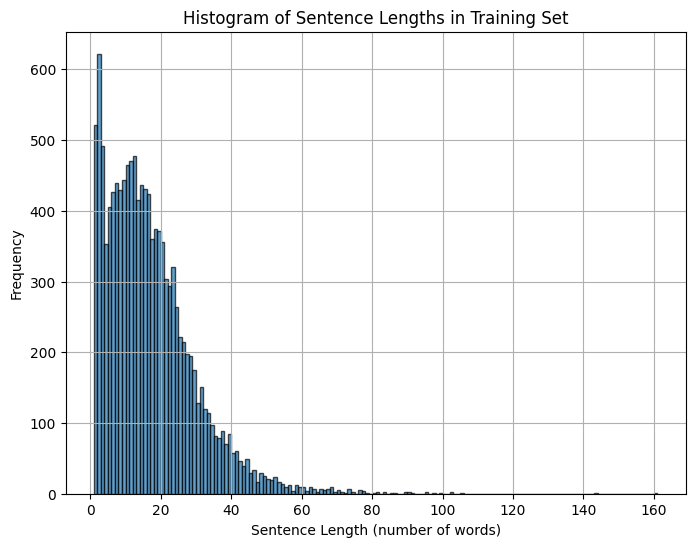

In [ ]:
# Calculate the length of each sentence (in terms of the number of words)
sentence_lengths = [len(sentence) for sentence in train_sentences]

print("Mean train sentence length: ", np.mean(sentence_lengths))

plt.figure(figsize=(8, 6))
plt.hist(sentence_lengths, bins=range(1, max(sentence_lengths) + 2), edgecolor='black', alpha=0.7)
plt.title("Histogram of Sentence Lengths in Training Set")
plt.xlabel("Sentence Length (number of words)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
word2vec = api.load("word2vec-google-news-300")  # 300-dimensional Word2Vec embeddings

In [ ]:
def preprocess_sentences(sentences, word2vec_model, max_length=50):
    embeddings = []
    labels = []

    for sentence in sentences:
        sentence_words = []
        sentence_labels = []

        for word, tag in sentence:
            # Get word embedding for each word
            if word in word2vec_model:
                sentence_words.append(word2vec_model[word])
            else:
                # Use a random vector for unknown words
                sentence_words.append(np.zeros(word2vec_model.vector_size))
            sentence_labels.append(tag)

        embeddings.append(sentence_words)
        labels.append(sentence_labels)

    # Pad the sequences to ensure all sentences have the same length
    embeddings = pad_sequences(embeddings, maxlen=max_length, padding='post', dtype='float32')

    # Convert POS tags (labels) to integers
    label_encoder = LabelEncoder()
    label_encoder.fit(np.unique([item for sublist in labels for item in sublist]))  # Fit on all unique POS tags

    padding_label = -1
    label_encoder.classes_ = np.insert(label_encoder.classes_, 0, padding_label)

    labels = [label_encoder.transform(sentence) for sentence in labels]
    labels = pad_sequences(labels, maxlen=max_length, padding='post', dtype='int32')


    return np.array(embeddings), np.array(labels), label_encoder.classes_

# Preprocess the train, dev, and test sentences
train_embeddings, train_labels, pos_tags = preprocess_sentences(train_sentences, word2vec)
dev_embeddings, dev_labels, _ = preprocess_sentences(dev_sentences, word2vec)
test_embeddings, test_labels, _ = preprocess_sentences(test_sentences, word2vec)


In [ ]:
pos_tags.sort()  # Sort for a consistent order

# Dictionary that maps index to POS tag
tag_to_idx = {pos_tags[i]: i for i in range(len(pos_tags))}
idx_to_tag = {i: pos_tags[i] for i in range(len(pos_tags))}


In [ ]:
# Convert the data to PyTorch tensors
train_embeddings_tensor = torch.tensor(train_embeddings)
train_labels_tensor = torch.tensor(train_labels)

dev_embeddings_tensor = torch.tensor(dev_embeddings)
dev_labels_tensor = torch.tensor(dev_labels)

test_embeddings_tensor = torch.tensor(test_embeddings)
test_labels_tensor = torch.tensor(test_labels)

# Create DataLoader for batching
train_data = TensorDataset(train_embeddings_tensor, train_labels_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

dev_data = TensorDataset(dev_embeddings_tensor, dev_labels_tensor)
dev_loader = DataLoader(dev_data, batch_size=64)

test_data = TensorDataset(test_embeddings_tensor, test_labels_tensor)
test_loader = DataLoader(test_data, batch_size=64)


In [ ]:
# Iterate through the first batch of the train_loader to check the dimensions
for inputs, labels in train_loader:
    print("Inputs shape:", inputs.shape)  # Check the input (embeddings) shape
    print("Labels shape:", labels.shape)  # Check the labels shape
    break  # Stop after the first batch


Inputs shape: torch.Size([64, 50, 300])
Labels shape: torch.Size([64, 50])


## CNNs Architecture, Training and Evaluation

In [ ]:
class POSCNN(nn.Module):
    def __init__(self, embedding_dim, num_classes, kernel_size=3, num_filters=128, max_length=50):
        super(POSCNN, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.max_length = max_length

        # 1D Convolutional layer
        self.conv1d = nn.Conv1d(in_channels=embedding_dim,
                                out_channels=num_filters,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2)

        # Fully connected layer for POS tag prediction
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        # Input shape: [batch_size, seq_len, embedding_dim]
        # Permute to [batch_size, embedding_dim, seq_len] for Conv1d
        x = x.permute(0, 2, 1)

        # Apply convolution: [batch_size, num_filters, seq_len]
        conv_out = self.conv1d(x)

        # Apply ReLU activation
        conv_out = torch.relu(conv_out)

        # Permute back to [batch_size, seq_len, num_filters]
        conv_out = conv_out.permute(0, 2, 1)

        # Fully connected layer to predict POS tags
        logits = self.fc(conv_out)  # [batch_size, seq_len, num_classes]

        return logits


In [ ]:
def train_and_evaluate_cnn(model_class, embedding_dim, num_classes, num_epochs=20):
    # Initialize the model
    model = model_class(embedding_dim, num_classes).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Handle PAD tokens
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate scheduler

    train_losses = []
    dev_losses = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_train_loss = 0

        for inputs, labels in train_loader:
            # Move data to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass through the model
            outputs = model(inputs)  # [batch_size, seq_len, num_classes]

            # Reshape outputs and labels for CrossEntropyLoss
            outputs = outputs.view(-1, num_classes)  # Flatten to [batch_size*seq_len, num_classes]
            labels = labels.view(-1).long()  # Flatten to [batch_size*seq_len]

            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model parameters

            total_train_loss += loss.item()

        train_losses.append(total_train_loss / len(train_loader))  # Average loss per batch
        scheduler.step()  # Update learning rate

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        total_dev_loss = 0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                outputs = outputs.view(-1, num_classes)
                labels = labels.view(-1).long()

                loss = criterion(outputs, labels)
                total_dev_loss += loss.item()

        dev_losses.append(total_dev_loss / len(dev_loader))  # Average loss per batch

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}")

    # Plotting training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", color='#00008B')
    plt.plot(range(1, num_epochs+1), dev_losses, label="Dev Loss", linestyle='--', color='#00008B')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Evaluate on the test set
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []  # To store predicted probabilities for AUC calculation

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # [batch_size, seq_len, num_classes]
            probs = F.softmax(outputs, dim=-1)  # Apply softmax to get probabilities
            preds = torch.argmax(probs, dim=-1)  # [batch_size, seq_len]

            # Flatten predictions, probabilities, and labels, excluding padding (ignore_index=0)
            for prob, pred, label in zip(probs, preds, labels):
                mask = label != 0  # Ignore PAD tokens
                y_true.extend(label[mask].cpu().numpy())
                y_pred.extend(pred[mask].cpu().numpy())
                y_prob.extend(prob[mask].cpu().numpy())

    # Convert numeric labels to POS tags using idx_to_tag
    y_true_tags = [idx_to_tag[idx] for idx in y_true]
    y_pred_tags = [idx_to_tag[idx] for idx in y_pred]

    # Classification report with tags instead of numeric class labels
    print(f"Classification Report for {model_class.__name__}:")
    print(classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, zero_division=0))

    # Calculate AUC scores for each class
    auc_scores = {}
    y_true_np = np.array(y_true)  # Ensure y_true is a NumPy array
    for i, class_name in enumerate(pos_tags):
        # AUC score for each class (one-vs-all)
        auc_score = roc_auc_score(
            (y_true_np == i).astype(int),  # True binary labels for the class
            [prob[i] for prob in y_prob]  # Predicted probabilities for the class
        )
        auc_scores[class_name] = auc_score

    # Print AUC scores
    print("\nAUC Scores for each class:")
    del auc_scores["-1"]
    for class_name, auc_score in auc_scores.items():
        print(f"{class_name}: {auc_score:.4f}")

    # Calculate Macro-Averaged Metrics
    report = classification_report(y_true_tags, y_pred_tags, target_names=pos_tags, output_dict=True, zero_division=1)
    precision_macro = report["macro avg"]["precision"]
    recall_macro = report["macro avg"]["recall"]
    f1_macro = report["macro avg"]["f1-score"]


    precision_recall_auc_macro = np.mean(list(auc_scores.values()))

    # Precision-Recall AUC (macro-average)
    print(f"\nMacro-Averaged Precision: {precision_macro}")
    print(f"Macro-Averaged Recall: {recall_macro}")
    print(f"Macro-Averaged F1: {f1_macro}")
    print(f"Macro-Averaged Precision-Recall AUC: {precision_recall_auc_macro}")

    return model


Epoch 1/20, Train Loss: 1.3503, Dev Loss: 0.2396
Epoch 2/20, Train Loss: 0.2105, Dev Loss: 0.1663
Epoch 3/20, Train Loss: 0.1724, Dev Loss: 0.1538
Epoch 4/20, Train Loss: 0.1593, Dev Loss: 0.1478
Epoch 5/20, Train Loss: 0.1519, Dev Loss: 0.1442
Epoch 6/20, Train Loss: 0.1466, Dev Loss: 0.1420
Epoch 7/20, Train Loss: 0.1426, Dev Loss: 0.1413
Epoch 8/20, Train Loss: 0.1388, Dev Loss: 0.1394
Epoch 9/20, Train Loss: 0.1354, Dev Loss: 0.1381
Epoch 10/20, Train Loss: 0.1324, Dev Loss: 0.1376
Epoch 11/20, Train Loss: 0.1275, Dev Loss: 0.1367
Epoch 12/20, Train Loss: 0.1270, Dev Loss: 0.1366
Epoch 13/20, Train Loss: 0.1266, Dev Loss: 0.1366
Epoch 14/20, Train Loss: 0.1263, Dev Loss: 0.1363
Epoch 15/20, Train Loss: 0.1259, Dev Loss: 0.1364
Epoch 16/20, Train Loss: 0.1256, Dev Loss: 0.1364
Epoch 17/20, Train Loss: 0.1253, Dev Loss: 0.1361
Epoch 18/20, Train Loss: 0.1250, Dev Loss: 0.1360
Epoch 19/20, Train Loss: 0.1246, Dev Loss: 0.1361
Epoch 20/20, Train Loss: 0.1243, Dev Loss: 0.1360


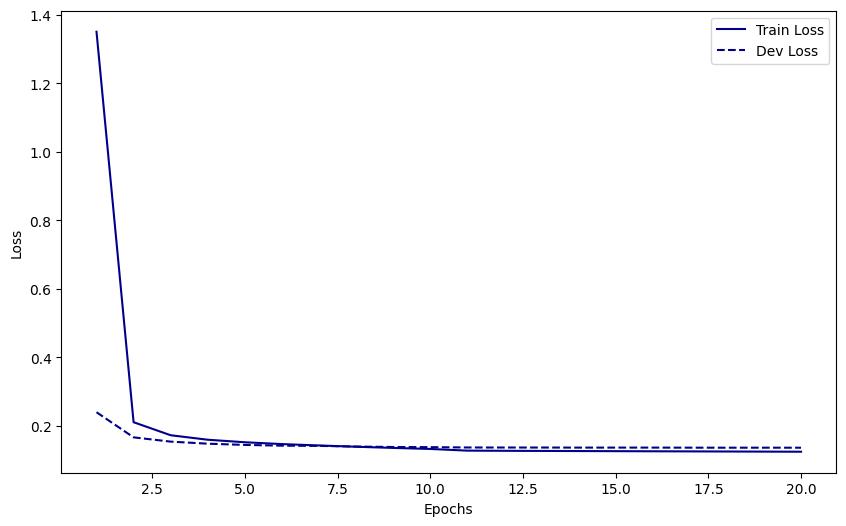

Classification Report for POSCNN:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
         ADJ       0.91      0.89      0.90      1781
         ADP       0.85      0.85      0.85      2009
         ADV       0.88      0.89      0.88      1174
         AUX       0.97      0.97      0.97      1531
       CCONJ       0.64      0.48      0.55       734
         DET       0.93      0.93      0.93      1881
        INTJ       0.91      0.79      0.85       121
        NOUN       0.91      0.90      0.90      4095
         NUM       0.75      0.49      0.59       538
        PART       0.86      0.86      0.86       642
        PRON       0.98      0.98      0.98      2145
       PROPN       0.90      0.80      0.84      2066
       PUNCT       0.74      0.80      0.77      3081
       SCONJ       0.91      0.78      0.84       378
         SYM       0.89      0.61      0.73       108
        VERB       0.93      0.93      0.93    


AUC Scores for each class:
ADJ: 0.9905
ADP: 0.9905
ADV: 0.9937
AUX: 0.9984
CCONJ: 0.9777
DET: 0.9969
INTJ: 0.9908
NOUN: 0.9875
NUM: 0.9480
PART: 0.9965
PRON: 0.9995
PROPN: 0.9756
PUNCT: 0.9766
SCONJ: 0.9943
SYM: 0.9531
VERB: 0.9957
X: 0.8609
_: 0.9910

Macro-Averaged Precision: 0.7887945702424318
Macro-Averaged Recall: 0.7791115085565101
Macro-Averaged F1: 0.7507063245541478
Macro-Averaged Precision-Recall AUC: 0.9787210696753399


In [ ]:
trained_model = train_and_evaluate_cnn(
    model_class=POSCNN,
    embedding_dim=300,        # Word2Vec embeddings are 300-dimensional
    num_classes=len(pos_tags),  # Number of unique POS tags
    num_epochs=20            # Number of epochs for training
)
